# Network Traffic Prediction with LSTM
In this notebook, we'll build LSTM models for a standard time series forecasting problem based on the Bluemix network traffic data. Then we'll use the models to predict future network traffic. 

This notebook contains the following sections:

- Problem Description
- Environment Preparation
- Load Network Traffic Data to Notebook
- Data Preparation
- Analyze Data
- Anomaly Detection
- Save Data to File 
- Build Multi-step LSTM Model
- Build One-step LSTM Model
- Save Model & Load Model in Production
- Summary

## Problem Description

The problem that we'll work on is the network traffic prediction problem for Bluemix platform. By using the Bluemix network data (received & transferred) collected within a 2-month period, we shall build a LSTM model to predict the future network trend.

Due to the nature of the input data, we'll be treating the network received traffic and the network transferred traffic as two separate datasets and build LSTM models for them respectively.

## Environment Preparation

Before we start working on the data, we need to import the following packages to set up the environment. We will be using the **Keras** open source neural network library, running on top of **Tensorflow**, to implement the LSTM model.

In [1]:
!pip install h5py

In [23]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dropout, Activation
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Network Traffic Data from Swift Object Storage

Now let's load the Bluemix network traffic data to this notebook. The data were provided via 6 CSV files, which we have uploaded to DSX. Thus, the data files are now stored in Bluemix object storage.

### Setup Username/Password of Swift 

Since we'll later publish this notebook to a public Github, we need to set the object storage credentials in a hidden cell to avoid the leaking of account information.  

In [24]:
# The code was removed by DSX for sharing.

###  Define the load_file Function

In [25]:
from io import StringIO
import requests
import json
import pandas as pd
def load_file(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': name,'domain': {'id':domain_id },
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)


### List CSV Files used for Training
There are six CSV files stored in object storage, which will be used for training and testing.

In [26]:
data_files=['env5_brain_192.155.247.207_20170401_20170601.csv',
            'env5_brain_169.55.245.30_20170401_20170601.csv',
            'env5_brain_169.54.213.198_20170401_20170601.csv',
            'env5_brain_10.143.131.55_20170401_20170601.csv',
            'env5_brain_10.143.123.125_20170401_20170601.csv',
            'env5_brain_10.107.77.247_20170401_20170601.csv']


### Load CSV Files to memory
We'll load the 6 CSV files to memory by using the ``load_file`` function defined above. The data is loaded as Pandas dataframe.

In [27]:
#data frames list to store contents in all csv file
dataframes=[]
for data_file in data_files:
    dataframes.append(pd.read_csv(load_file(container, data_file)))


## Data Preparation
As we have now loadded the CSV files to this notebook, we need to analyze the datasets to prepare the data for modelling. The 6 CSV files represent the received and transferred network flow of 6 Bluemix nodes, accross the same time period of about 60 days. The **timestamp** colume in the CSV files indicates the time when the network data was collected, while each timestamp is separated by the same interval of 5 minutes. 

Since the 6 Bluemix nodes come from the same cluster and share workload within the cluster, we will merge the network traffic data in the 6 CSV files to form a new dataset for modelling. To do this, we first need to retrieve the timestamp series as we will merge the network data with the same timestamp. 

Moreover, as the 5 minute intervals are a bit too small for detecting the network traffic patterns, we will accumulate the data to present the network traffic of each hour.

Once done, we will also need to normalize the dataset by rescaling the data values to the range of 0-to-1, which is a good practice for using the LSTM model.

In conclusion, for this section, we will prepare the data with the following steps:
 - Retrieve Timestamp Series
 - Merge Six Datasets into One 
 - Compute Hourly Network Traffic
 - Normalize Dataset

### Retrieve Timestamp Series
First of all, we retrieve all timestamps in data files. The timestamps represent the time when the network traffic data was collected, i.e. every 5 minutes. However, there might be interruptions in the monitoring system, breaking the data collection, and thus we will verify if there’s any timestamp missing from the dataset. For such cases, we will add the timestamp with a default traffic value of 0. This is because most monitoring systems would pick up the missing traffic volume during the next check if the previous data collection was interrupted.

In [28]:
timestamps=set()
for dataframe in dataframes:
    for t in (dataframe['timestamp']):
        timestamps.add(t)

ts=sorted(timestamps)
for i in range(1,len(ts)):
    prev=ts[i-1]
    while(ts[i]-prev)>400:
        prev+=300
        ts.append(prev)

ts=sorted(ts)


In [29]:
#save ts_2_indx and idx_2_ts
ts_2_idx=dict((i,v) for(i,v)  in enumerate(ts))
idx_2_ts=dict((v,i) for(i,v)  in enumerate(ts))

### Merge Six Datasets into One 
Since all 6 nodes are in the same cluster and only one node is under Active mode at one time, we merge all traffic from the 6 nodes according to the timestamp.

In [30]:
merged_input=np.empty(shape=(0,2))
for t in ts:
    sum_received=0
    sum_transferred=0
    for dataframe in dataframes:
        row=dataframe[dataframe['timestamp']==t]
        cur_received=row.get('net_received',0)
        cur_transfer=row.get('net_transferred',0)
        for ind in cur_transfer.index:
            sum_transferred+=cur_transfer[ind]
        for ind in cur_received.index:
            sum_received+=cur_received[ind]
    merged_input=np.append(merged_input,[[sum_received,sum_transferred]],axis=0)


#### Display network received traffic graph  

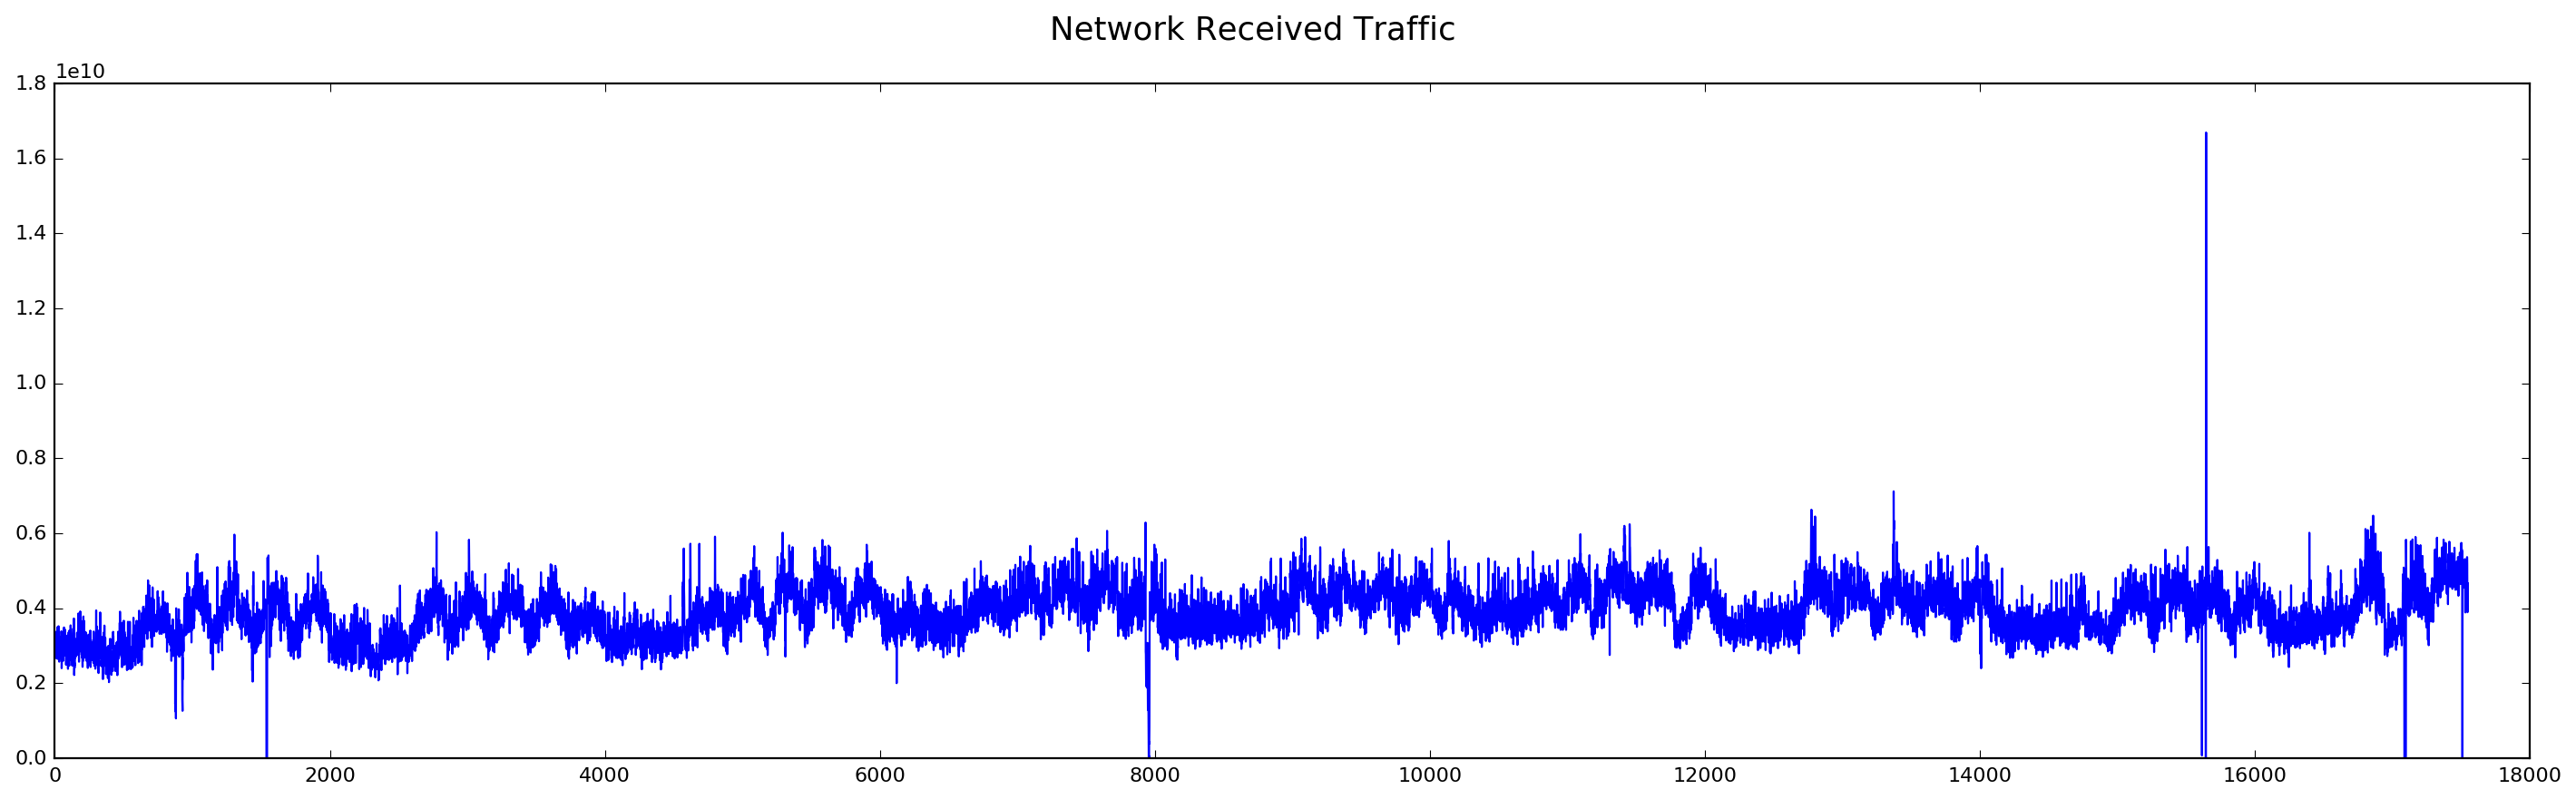

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Received Traffic', fontsize=16)
plt.plot(merged_input[:,0:1])
plt.show()

#### Display network transferred traffic graph  

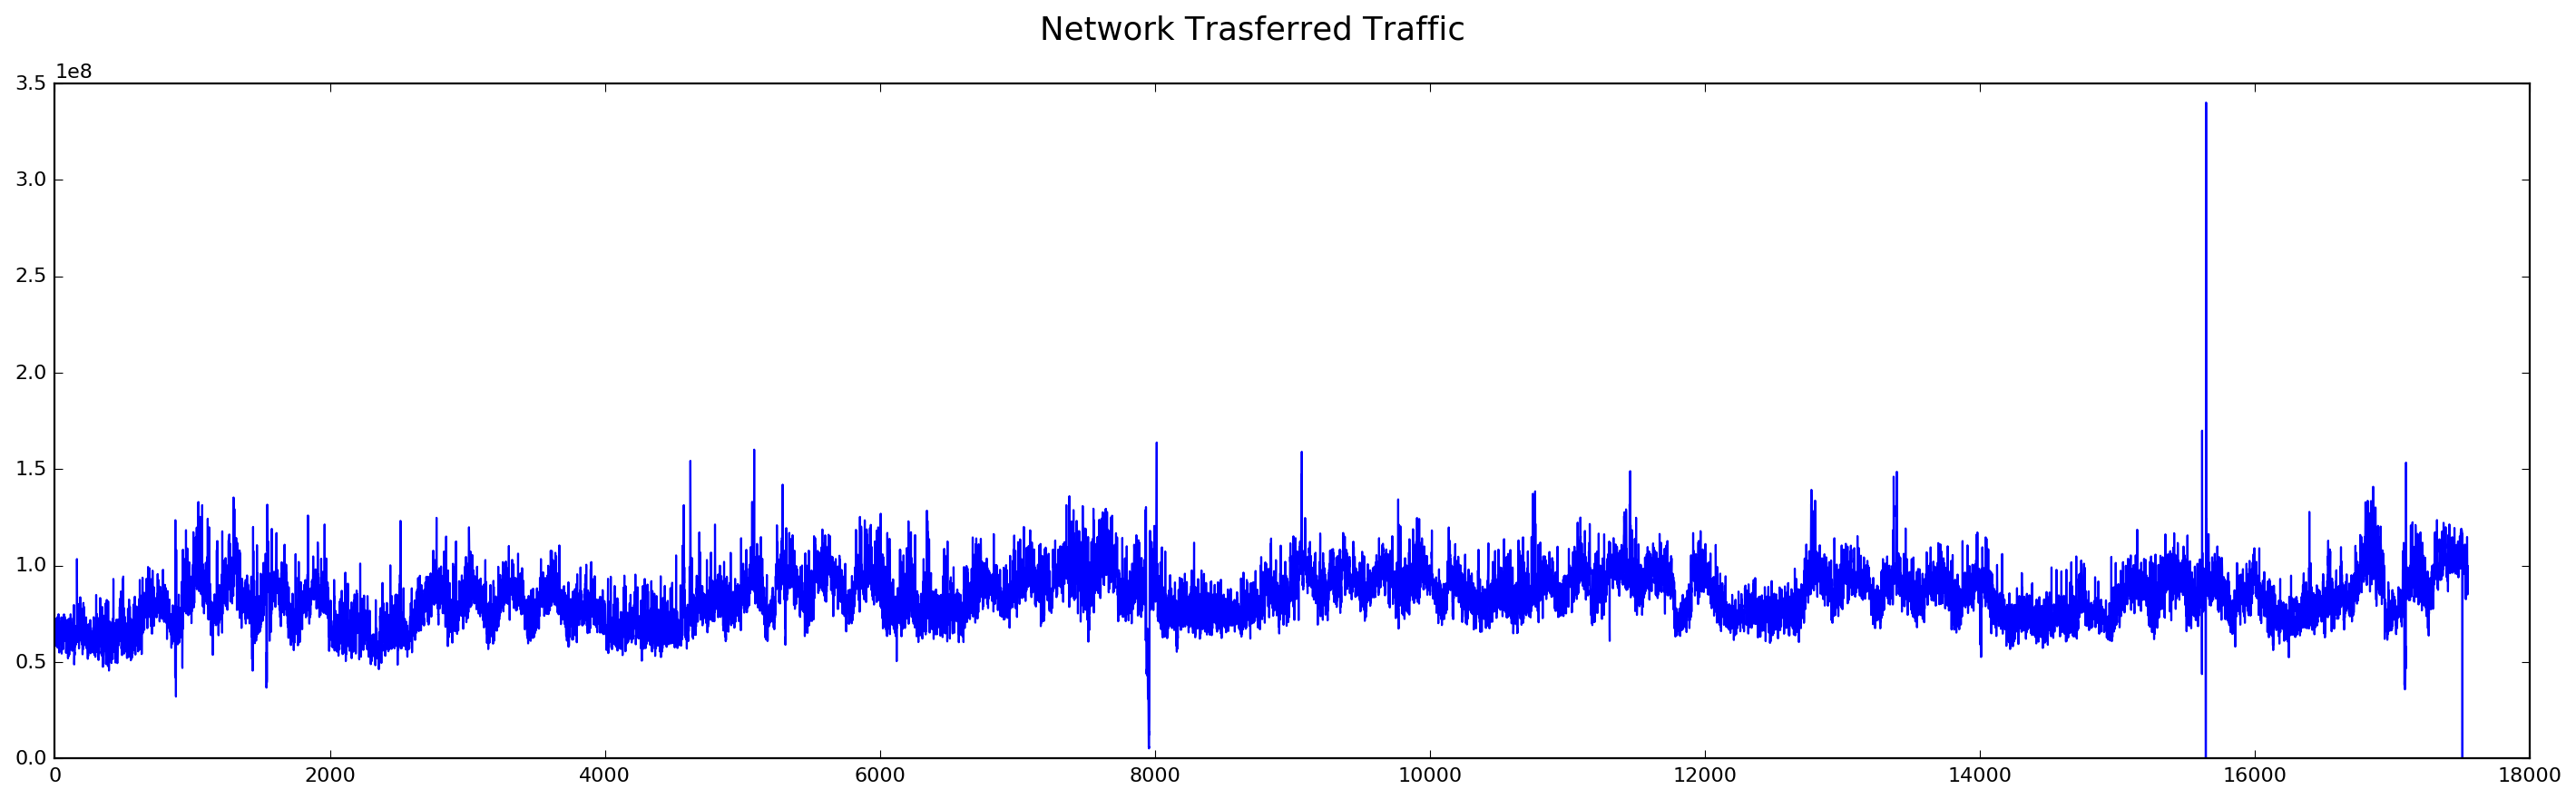

In [57]:
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Trasferred Traffic', fontsize=16)
plt.plot(merged_input[:,1:2])
plt.show()

### Compute Hourly Network Traffic
The timestamps are recorded in 5min-intervals, which are a bit too small for capturing the network flow trends. Therefore, we accumulate the network traffic data on hourly bases. 

In [31]:
hourly_input=np.empty(shape=(0,2))
size=merged_input.shape[0]
for i in range(0,size,12):
    slice=merged_input[i:i+12,:]
    hourly_rev=0
    hourly_transfer=0
    for s in slice:
        hourly_rev+=s[0]
        hourly_transfer=s[1]
    hourly_input=np.append(hourly_input,[[hourly_rev,hourly_transfer]],axis=0)

#### Display hourly network traffic graph  

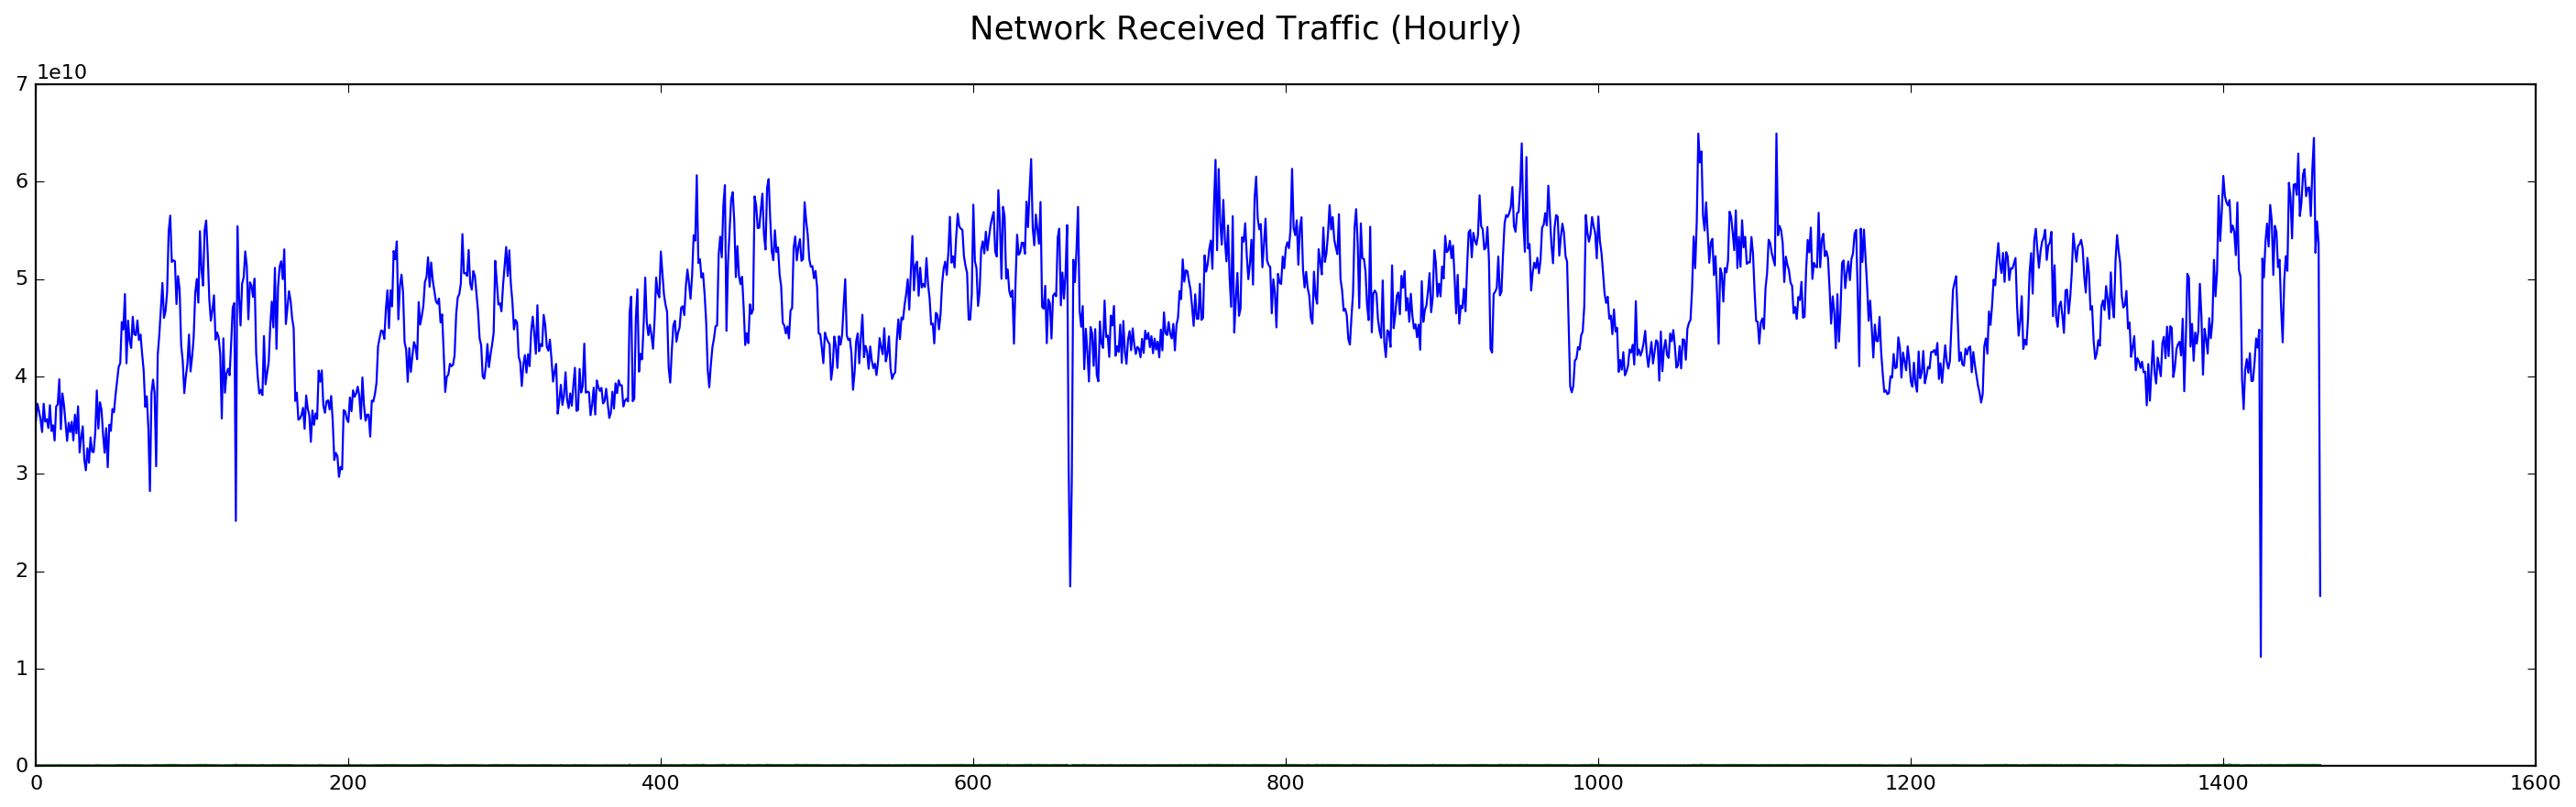

In [12]:
# net_received traffic flow
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Received Traffic (Hourly)', fontsize=16)  
plt.plot(hourly_input)
plt.show()

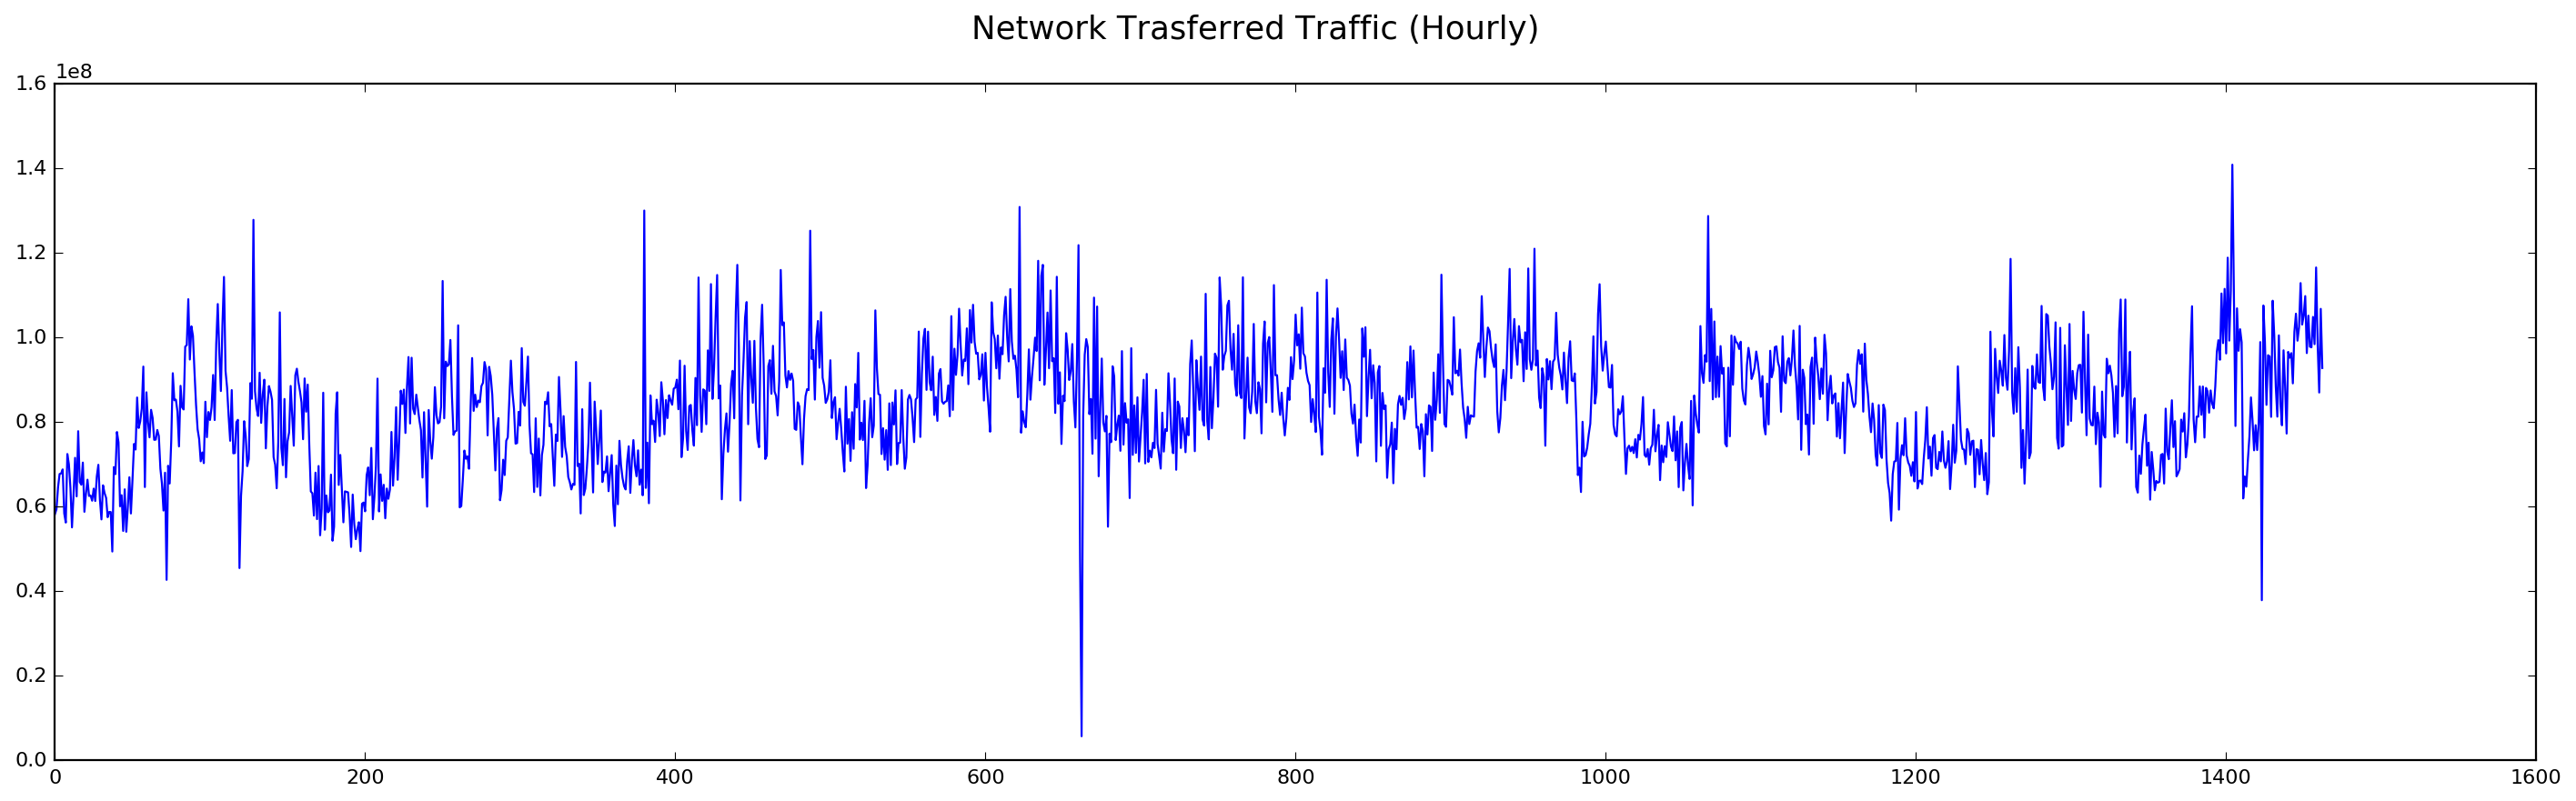

In [13]:
# net_trasferred traffic flow
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Trasferred Traffic (Hourly)', fontsize=16) 
plt.plot(hourly_input[:,1:2])
plt.show()

### Normalize Dataset into (0,1) 
LSTM models are sensitive to the scale of the input data, which is why we will rescale the data to the range of 0-to-1, i.e. normalization. 

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_receive = scaler.fit_transform(hourly_input[:,0:1])

scaler2 = MinMaxScaler(feature_range=(0, 1))
dataset_transfer = scaler2.fit_transform(hourly_input[:,1:2])

#### Plot diagram after data normalization

The recieved network traffic is plot in blue, while the transferred traffic is plot in green. We can see that both traffic data follow the same trend.

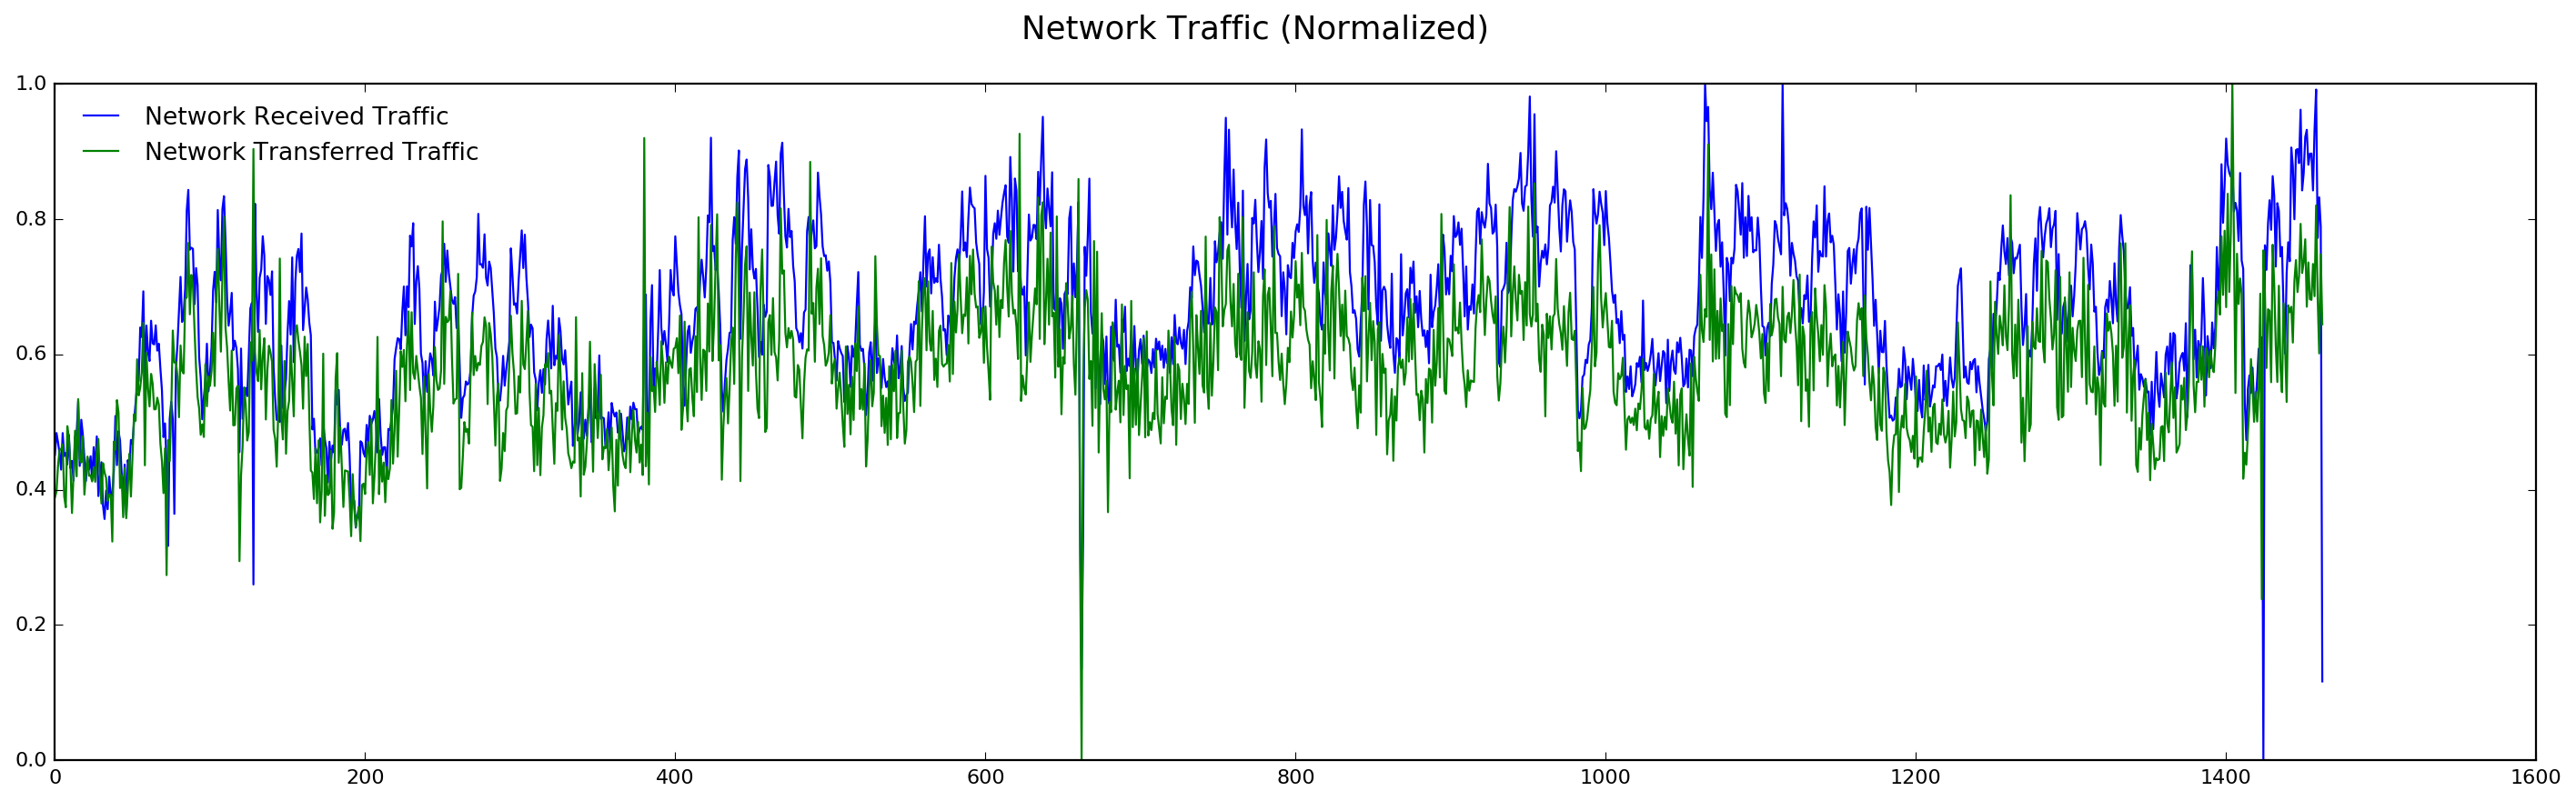

In [15]:
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Traffic (Normalized)', fontsize=16) 
plt.plot(dataset_receive, color="blue", label="Network Received Traffic")
plt.plot(dataset_transfer, color="green" , label="Network Transferred Traffic")
plt.legend(loc='upper left', frameon=False)
plt.show()

## Analyze Data

Here we will analyze the network traffic data to see if there's any pattern to be traced. Thus, we have the following figure with vertical lines separating the data according to days (24 hours). The lines in green stand for weekends (Saturday and Sunday), orange for Mondays, and pink for other weekdays. The network received traffic is plot in blue, while the network transferred traffic is in green. 

In [16]:
import datetime

dtime = pd.Series()

for i in range(0,len(ts),12):
    d=datetime.datetime.fromtimestamp(ts[i])
    d1=pd.Series([d]) 
    dtime=dtime.append(d1)

dtime.reset_index(drop=True, inplace=True)

xdate = pd.Series()

for i in range(1,len(dtime),1):
    if dtime[i-1].date() < dtime[i].date(): 
        d2 = pd.Series([i])  
        xdate = xdate.append(d2)

xdate.reset_index(drop=True, inplace=True)


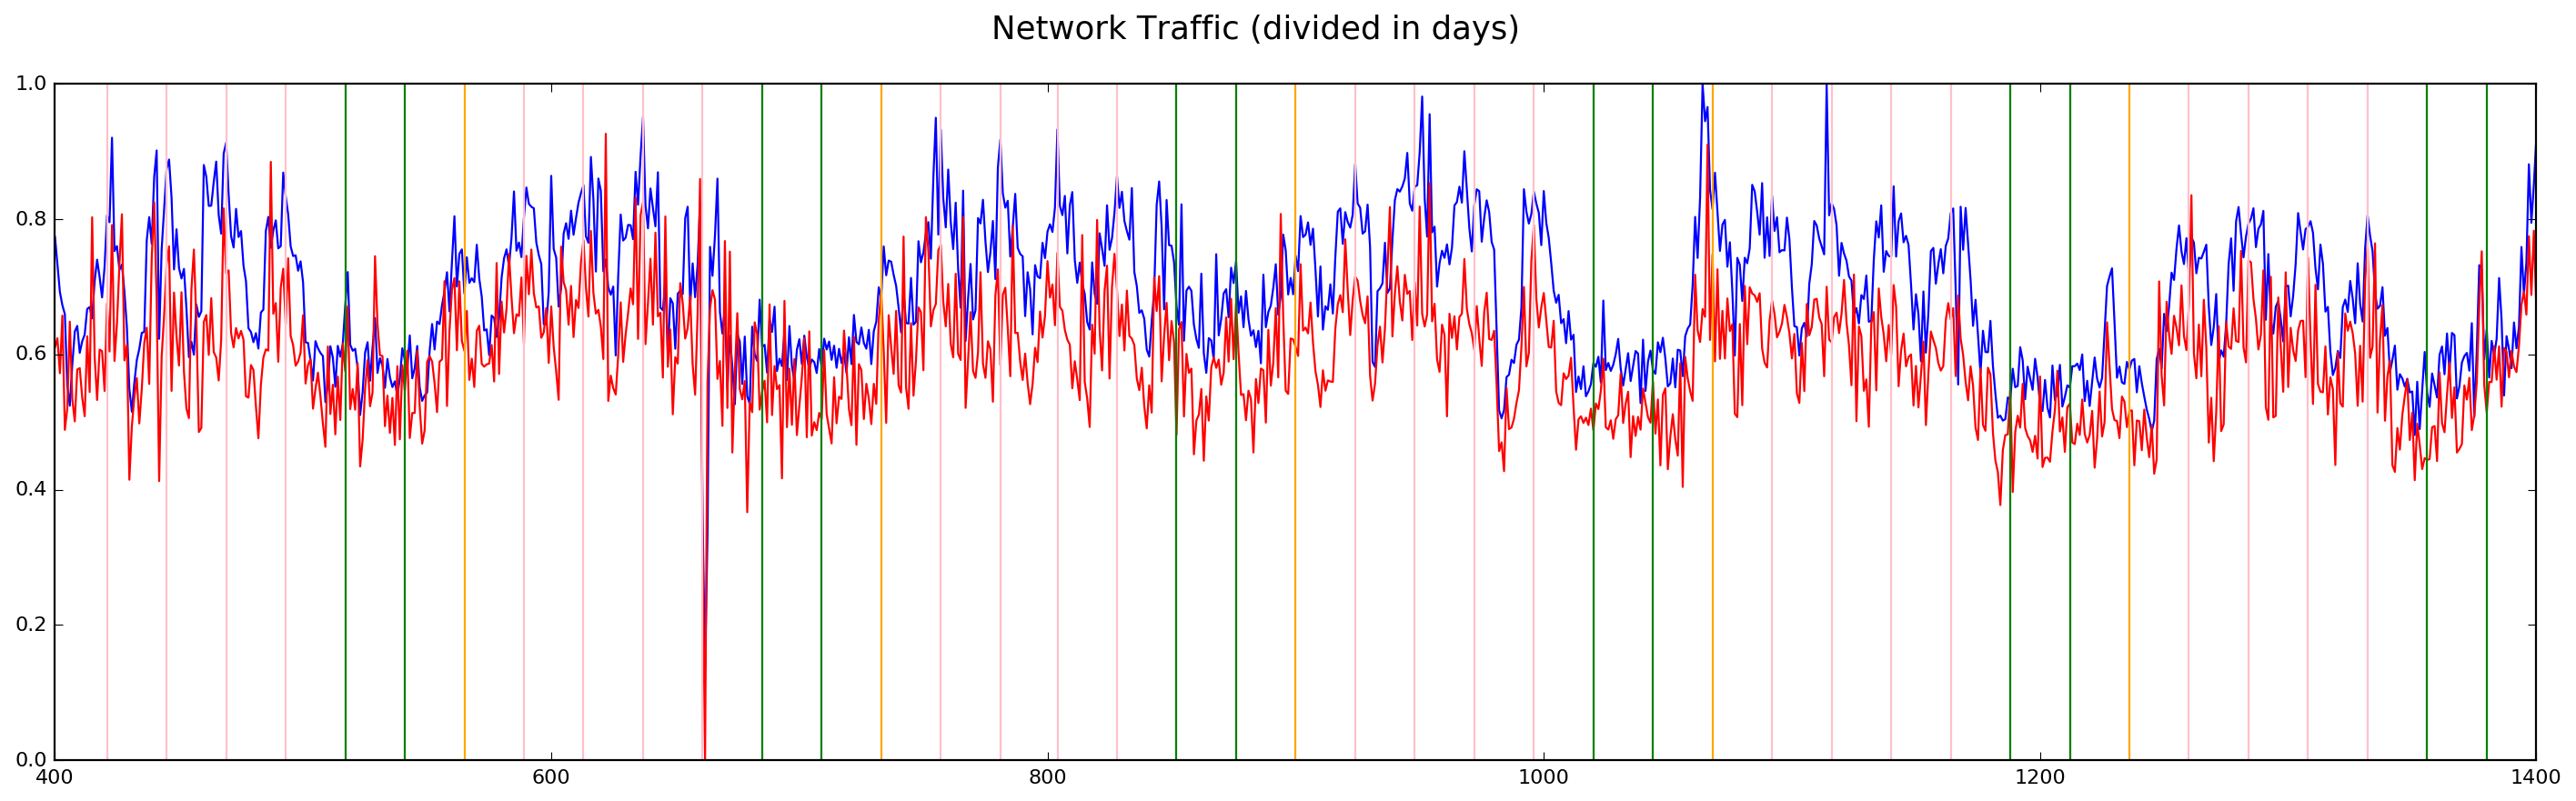

In [17]:
# Weekends (Sunday & Saturday) are plot in green
# Mondays are plot in orange
# Other workdays are in pink

plt.figure(figsize=(22,6), dpi=80)
plt.xlim(400,1400)
plt.suptitle('Network Traffic (divided in days)', fontsize=16) 
plt.plot(dataset_receive, color="blue")
plt.plot(dataset_transfer, color="red")
for i in range(len(xdate)):
    aa=xdate[i]
    if dtime[aa].date().weekday()== 0:
        plt.axvline(xdate[i], color = "orange")
    elif dtime[aa].date().weekday()>4:
        plt.axvline(xdate[i], color = "green")
    else:
        plt.axvline(xdate[i], color = "pink")
plt.show()

From the data analysis, we can see that the network traffic data represents unique trends within a week period, with relatively low traffic during weekends and high traffic during weekdays. Also, there's usually a drop in the traffic amount during the middle of the day, which makes sense as considering the time difference between US and China.

## Anomaly Detection
From the figures above, we can see that there are a few data points plotted far away from the major dataset, which should be treated as normality.

Thus, in this section, we will detect the abnormal data points and remove them from the dataset. To do this, we'll need to define a boundary around normal data points so that they can be distinguishable from outliers.

### Define Boundary 

Since most of the network traffic is distributed within an area of 0.4 to 0.9 (normalized), we'll use the Gaussian distribution to detect the abnormal data points, which should have quite low occurrence rates in the distribution.  

Here we use 3\*sigma to find the abnormal ponits outside the range of 99.73% (boundary) from a Gaussian distribution. In other words, we will only handle the most obvious outliners (less than 0.3% of occurrence) as the LSTM model should be able to detect the rest of the abnormal network traffic and "forget" them during memory update. 

The following are the figures of the Gaussian distribution of network received traffic and network transferred traffic respectively.

mu=[ 0.66162176]
sigma=0.0149741429868


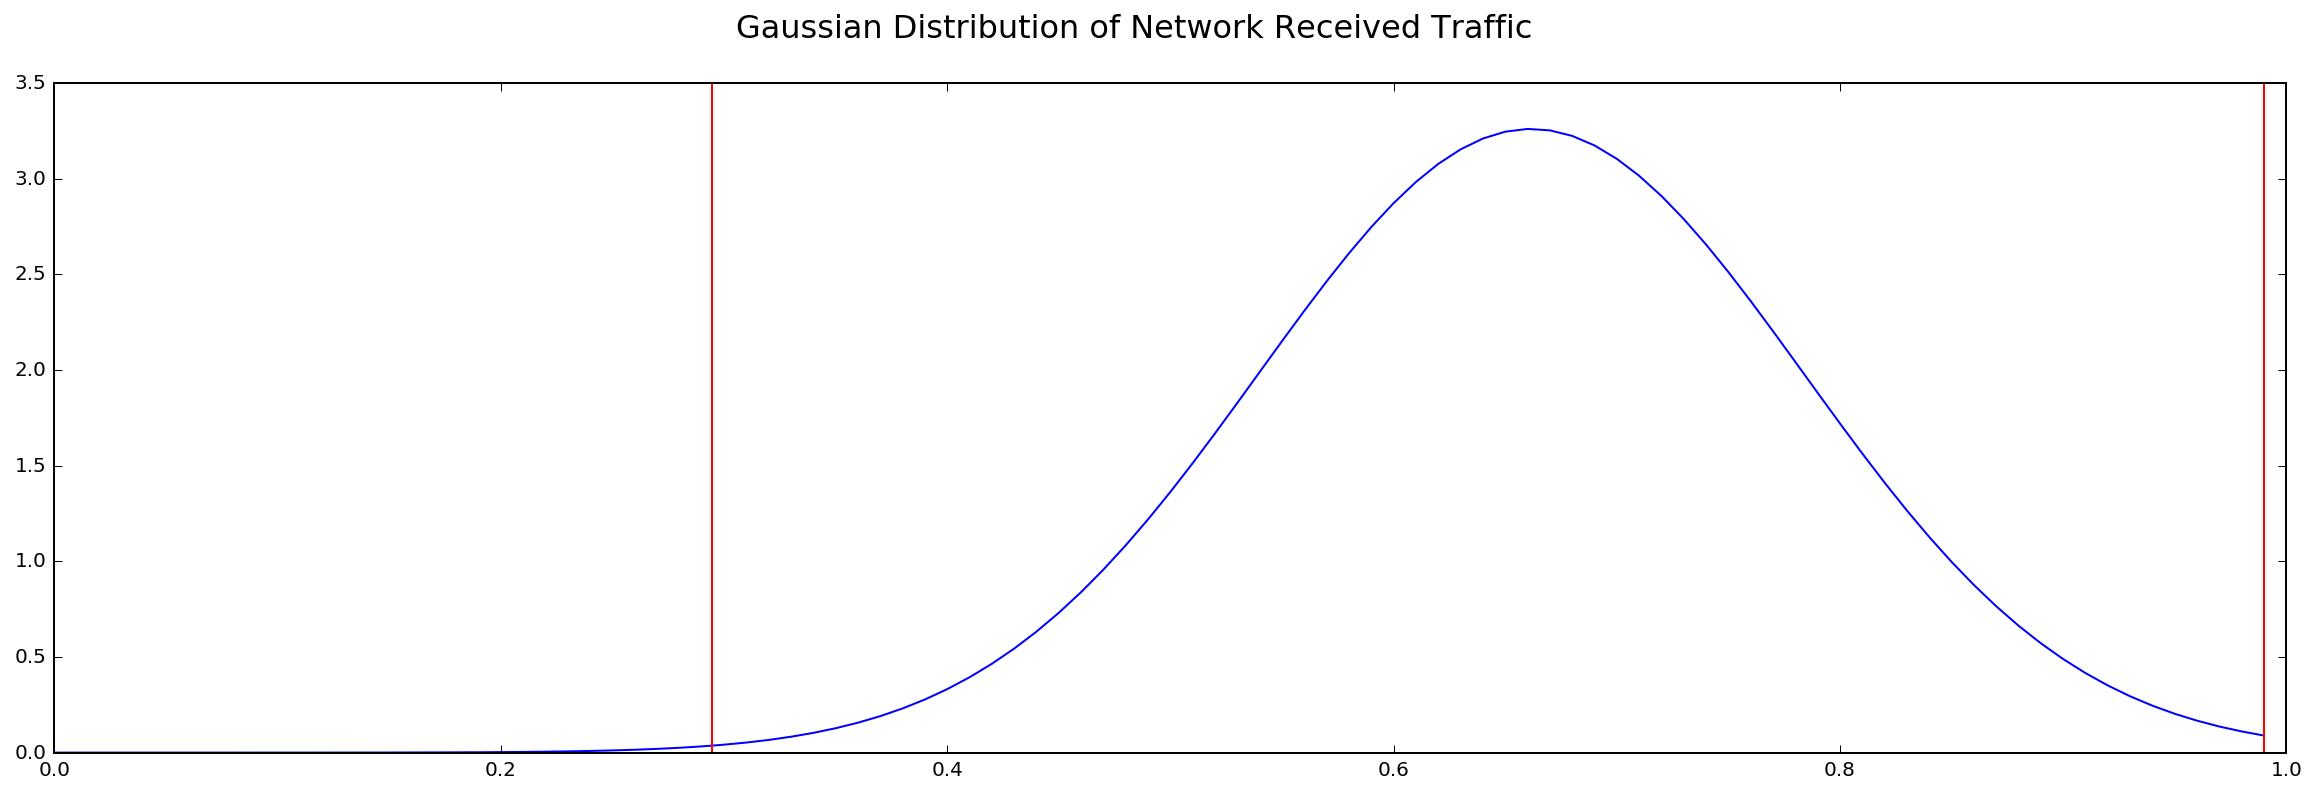

mu=[ 0.57484082]
sigma=0.00993445991024


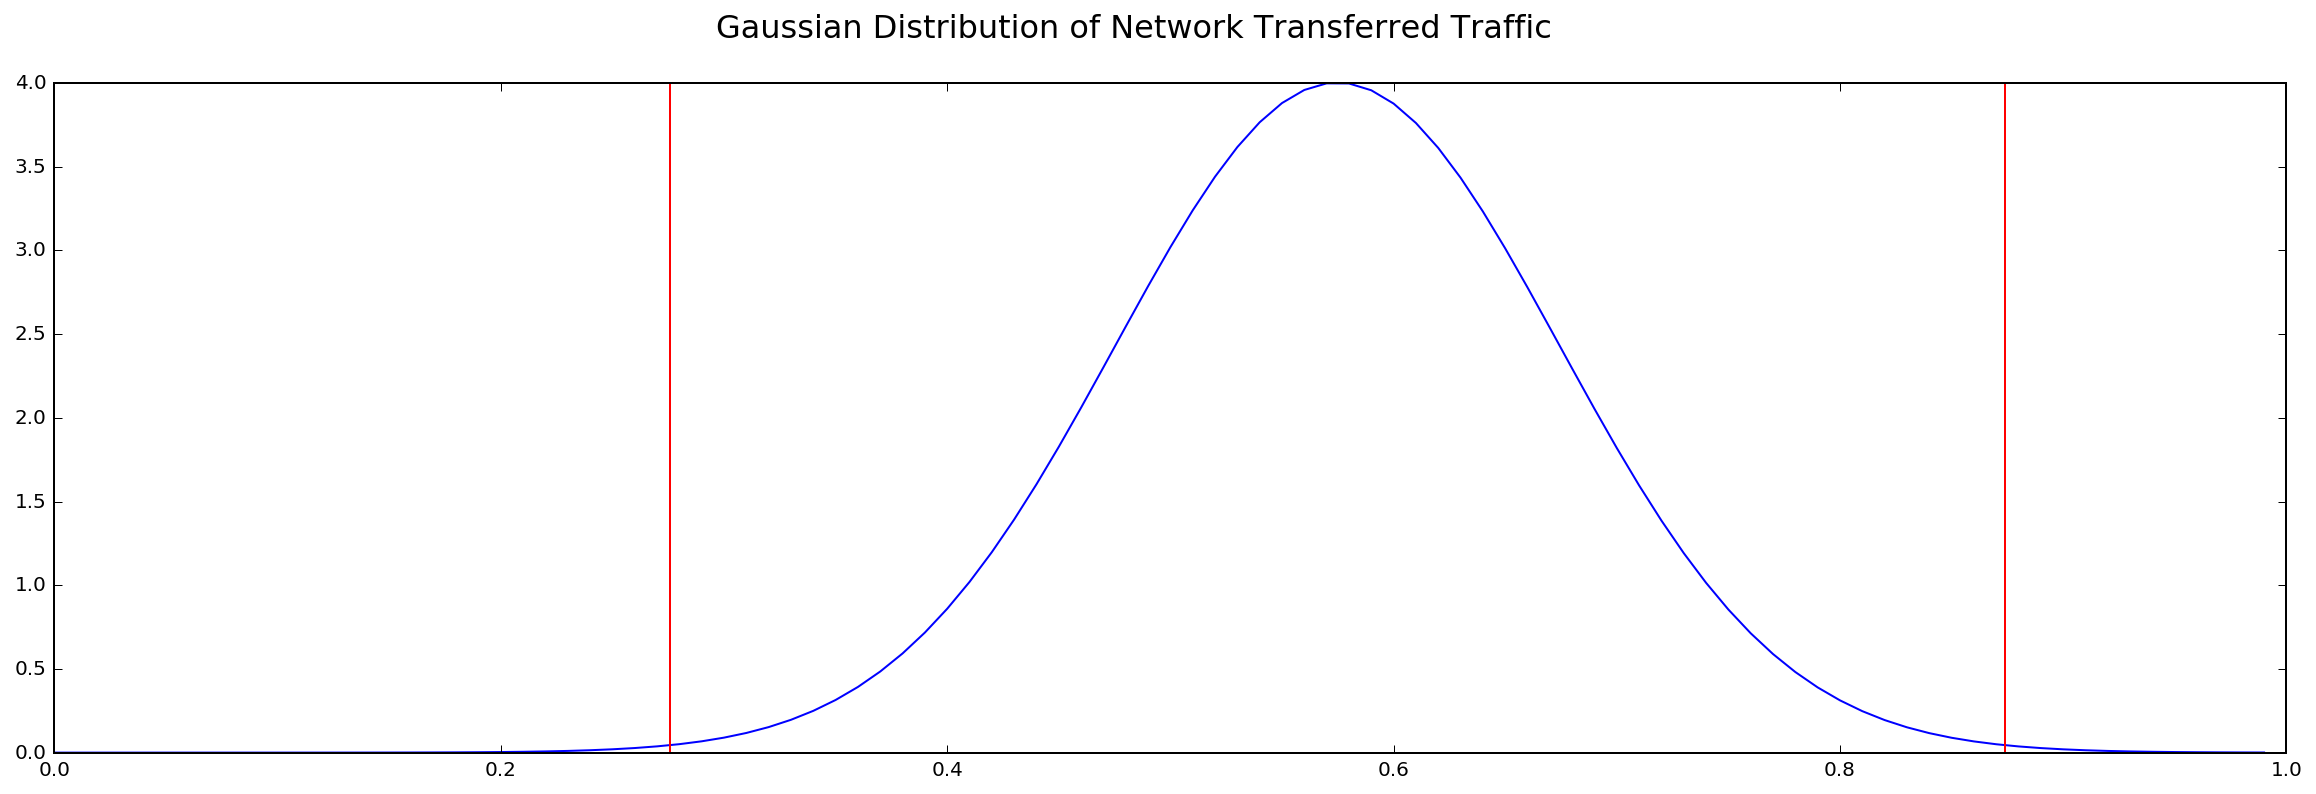

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
from scipy.stats import multivariate_normal
import math

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


def find_outline_boundary(dataset, title):
    array_data = np.asarray(dataset) 
    mu, sigma = estimateGaussian(array_data)
    print("mu=" + str(mu))
    print("sigma=" + str(sigma))
    
    sqrt_sigma=math.sqrt(sigma) 
    outline1 = mu[0]-sqrt_sigma*3
    outline2 = min(mu[0]+sqrt_sigma*3, 0.99)

    x1 = np.linspace(0, 1, 100, endpoint=False)
    y1 = multivariate_normal.pdf(x1, mean=mu, cov=sigma);
    
    plt.figure(figsize=(20,6))
    plt.suptitle(title, fontsize=16) 
    plt.plot(x1, y1)
    plt.axvline(x=outline1, color = "red")
    plt.axvline(x=outline2, color = "red")
    plt.show()
    return outline1, outline2

dataset_receive_outline1, dataset_receive_outline2 = find_outline_boundary(dataset_receive, "Gaussian Distribution of Network Received Traffic")
dataset_transfer_outline1, dataset_transfer_outline2 = find_outline_boundary(dataset_transfer, "Gaussian Distribution of Network Transferred Traffic")

### Adjust Abnormal Points

Now that we have the boundaries defined, dividing the abnormal data points from the normal network dataset, we shall adjust the abnormal data so that they could land in the normal data range.

The following figures list the outliers of network received traffic and network transferred traffic respectively.

[128, 662, 1064, 1114, 1424, 1458, 1462]
[array([ 0.25976534]), array([ 0.13452947]), array([ 0.99985628]), array([ 1.]), array([ 0.]), array([ 0.99140815]), array([ 0.11646699])]


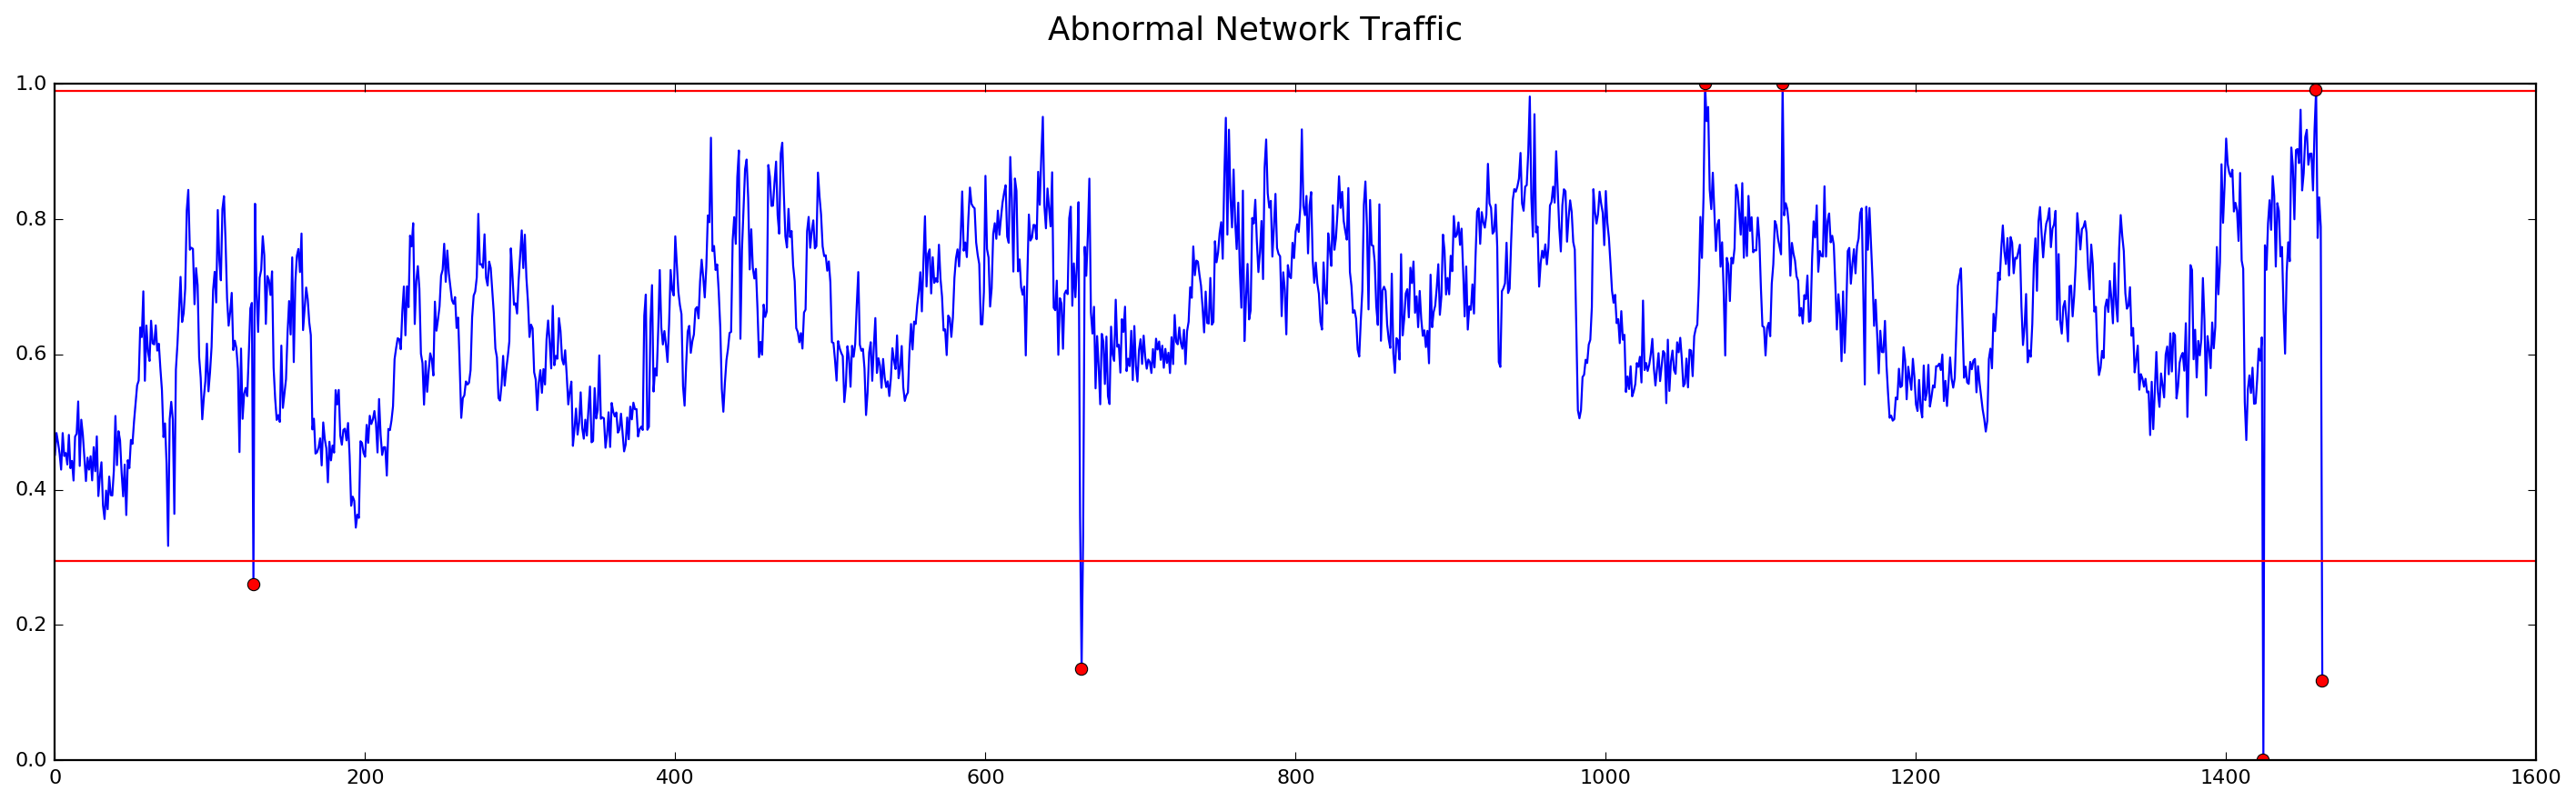

[72, 128, 380, 487, 622, 662, 1066, 1404, 1423]
[array([ 0.27359803]), array([ 0.90348855]), array([ 0.9197858]), array([ 0.88449436]), array([ 0.92600778]), array([ 0.]), array([ 0.91014605]), array([ 1.]), array([ 0.23799429])]


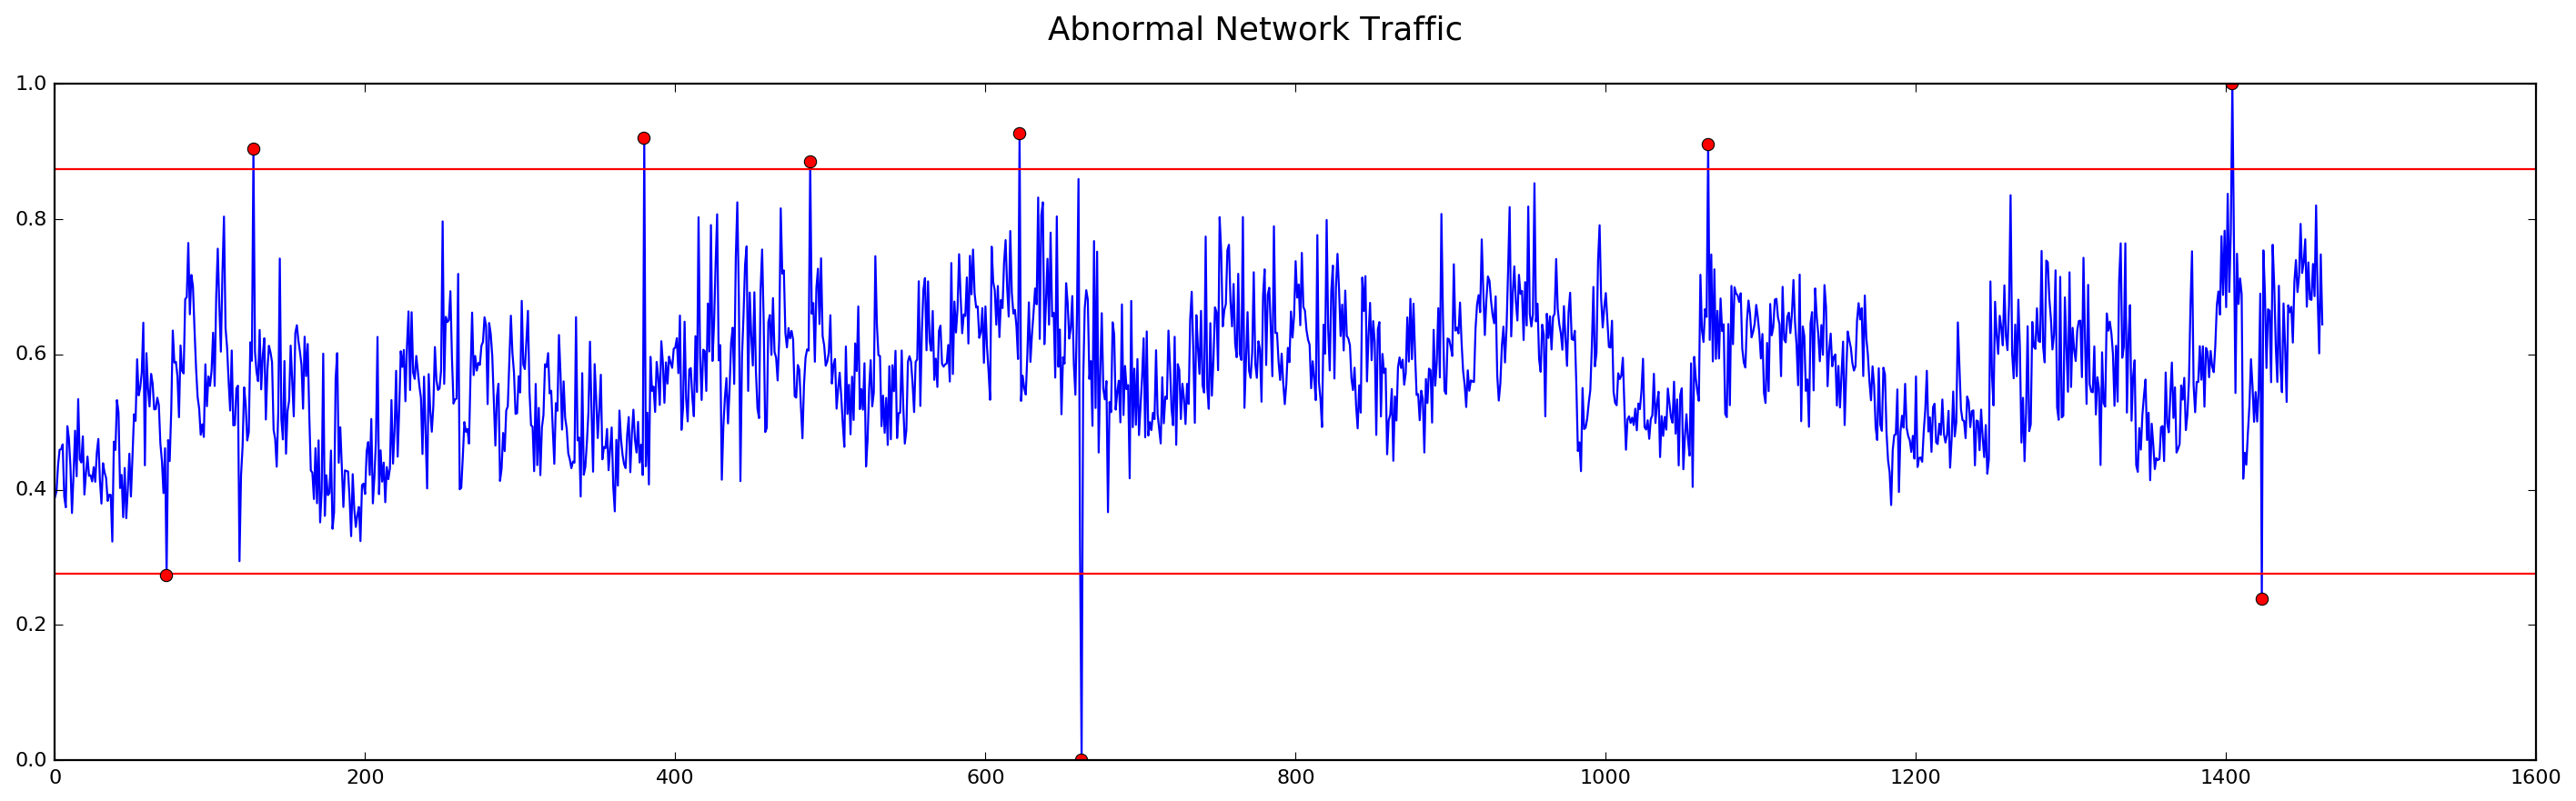

In [19]:
def find_outline_points(outline1, outline2, dataset):

    xaxis = []
    yaxis = []

    for i in range(len(dataset)):
        if dataset[i]<outline1 or dataset[i]>outline2:
            xaxis.append(i)
            yaxis.append(dataset[i])
             
                         
    print(xaxis)
    print(yaxis)

    plt.figure(figsize=(22,6), dpi=80)
    plt.suptitle('Abnormal Network Traffic', fontsize=16) 
    plt.plot(dataset, color="blue")
    plt.axhline(y=outline1, color = "red")
    plt.axhline(y=outline2, color = "red")
    plt.plot(xaxis, yaxis, "ro", color = "red")
    plt.show()
    return xaxis, yaxis

dataset_receive_x, dataset_receive_y = find_outline_points(dataset_receive_outline1, dataset_receive_outline2, dataset_receive)
dataset_transfer_x, dataset_transfer_y = find_outline_points(dataset_transfer_outline1, dataset_transfer_outline2, dataset_transfer)



The following figures show that after adjusting the abnormal points, we now have all network data inside the outlier boundaries (occurrence rate of 99.73%). 

(128, array([ 0.46757761]))
(662, array([ 0.29451512]))
(1064, array([ 0.69989939]))
(1114, array([ 0.7]))
(1424, array([ 0.6]))
(1458, array([ 0.6939857]))
(1462, array([ 0.29451512]))


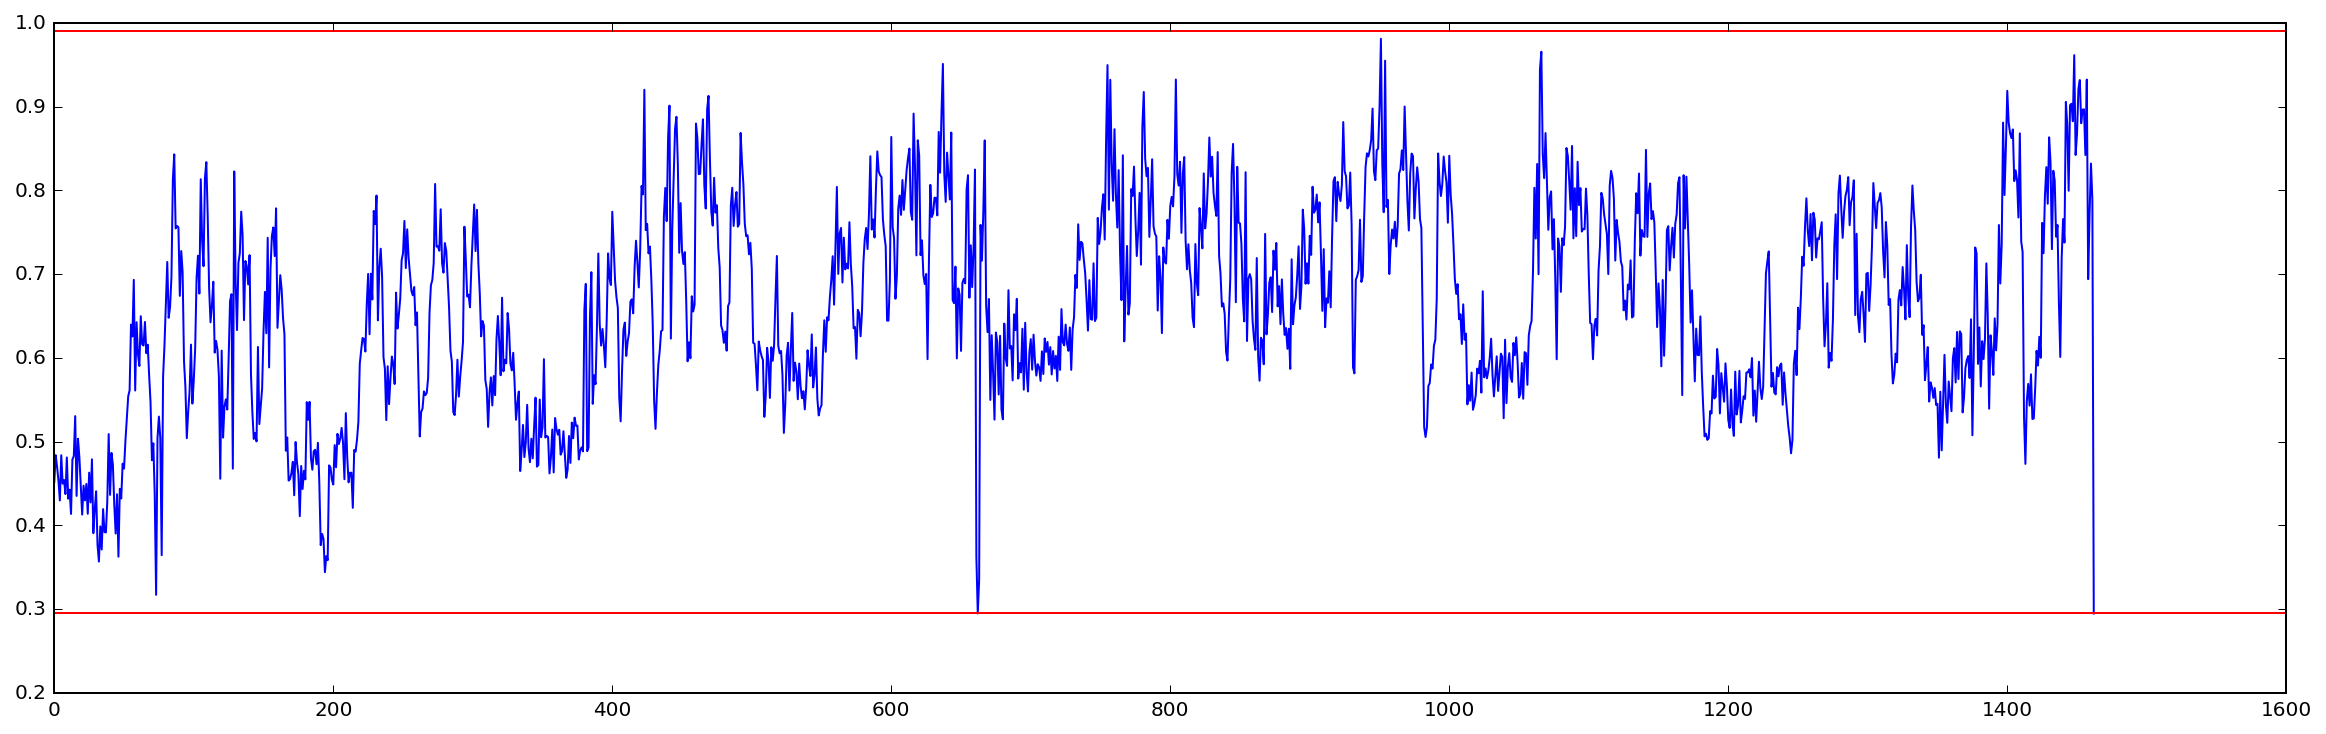

(72, array([ 0.49247645]))
(128, array([ 0.63244198]))
(380, array([ 0.64385006]))
(487, array([ 0.61914606]))
(622, array([ 0.64820544]))
(662, array([ 0.6]))
(1066, array([ 0.63710223]))
(1404, array([ 0.7]))
(1423, array([ 0.42838972]))


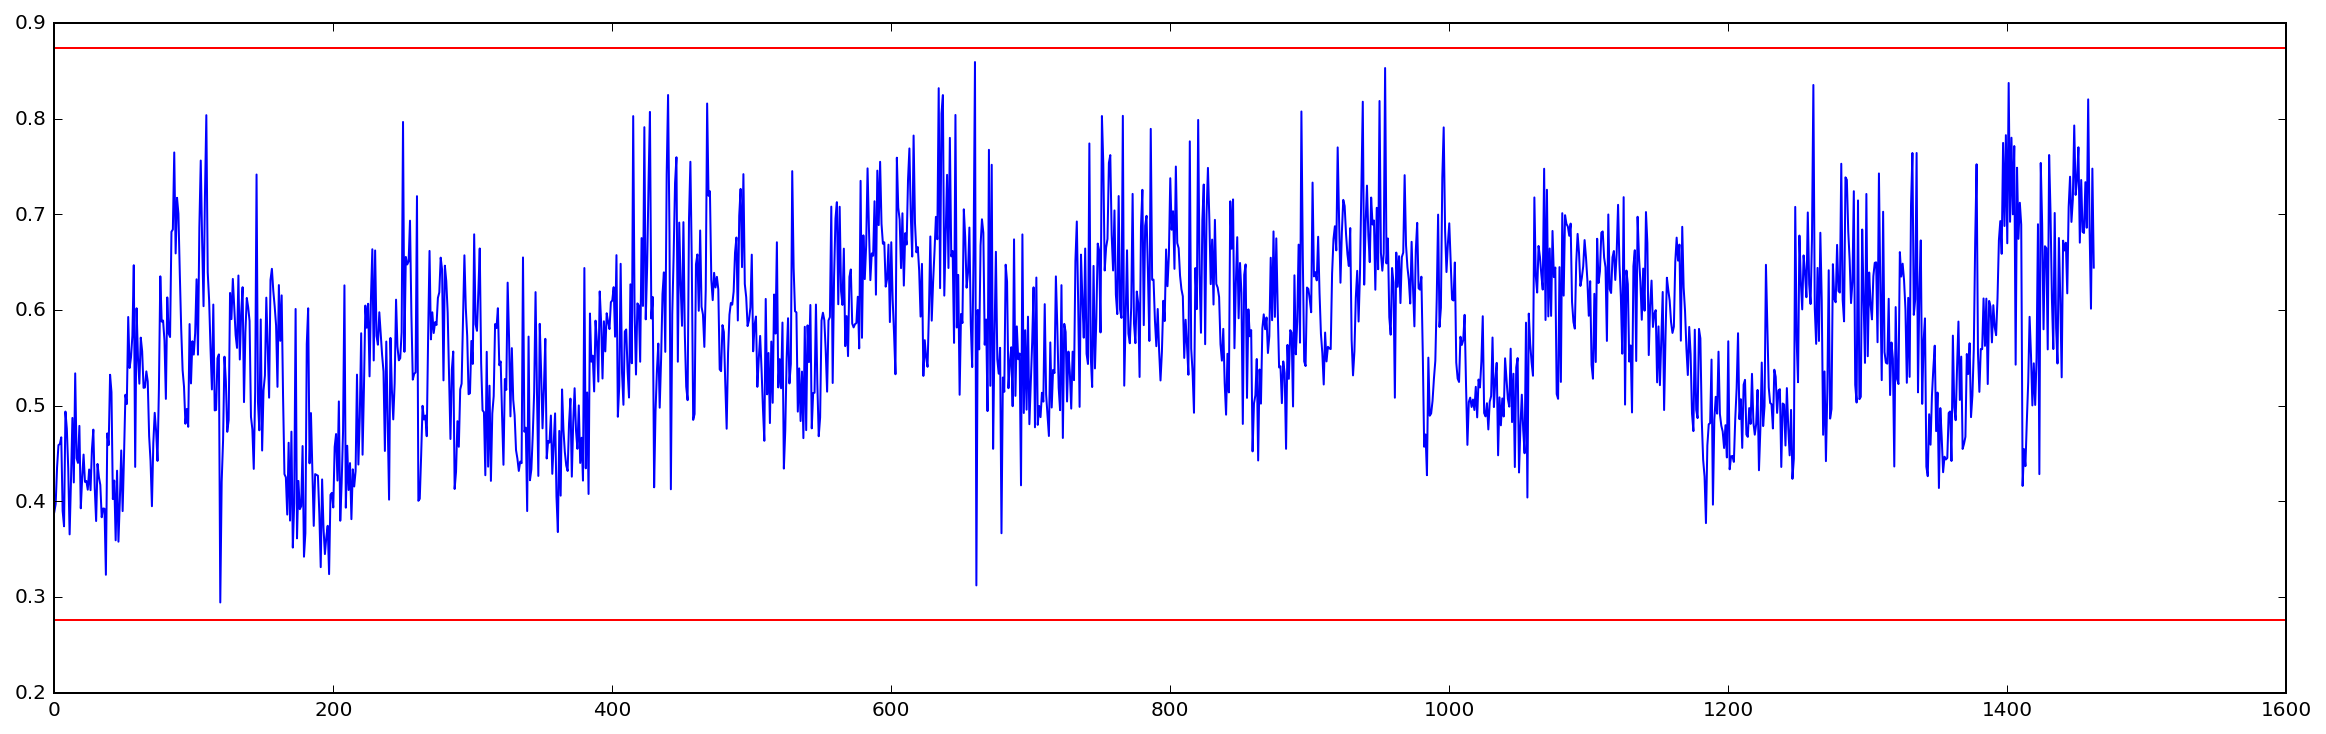

In [20]:
def remove_outliner(outline1, outline2, xaxis, yaxis, dataset):
    

    for i in range(len(xaxis)):
        a=xaxis[i]
        if yaxis[i]==0:
            dataset[a]=0.6
        elif yaxis[i]>0.5:
            dataset[a]=dataset[a]*0.7
        elif yaxis[i]<0.5:
            dataset[a]=max(dataset[a]*1.8, outline1)
        print(a, dataset[a])

    
    plt.figure(figsize=(20,6))
    plt.plot(dataset)
    plt.axhline(y=outline1, color = "red")
    plt.axhline(y=outline2, color = "red")
    plt.show()
    return dataset

dataset_receive= remove_outliner(dataset_receive_outline1, dataset_receive_outline2, dataset_receive_x, dataset_receive_y, dataset_receive)
dataset_transfer= remove_outliner(dataset_transfer_outline1, dataset_transfer_outline2, dataset_transfer_x, dataset_transfer_y, dataset_transfer)

## Checkpoint--Save Processed Data to File

Now that we've completed all the data processing and preparation work, let's save the updated datasets to files so that we don't need to start all over again with the data preparation when kernel restarts.

In [7]:
dataset_receive_file='dataset_receive.pkl'
dataset_transfer_file='dataset_trasnfer.pkl'

np.save(dataset_receive_file,dataset_receive,allow_pickle=True)
np.save(dataset_transfer_file,dataset_transfer,allow_pickle=True)

In [22]:
!ls -al

total 10088184
drwx------  2 sffc-3691fbb0f320c6-8c20818cd6ff users       4096 Jul 21 02:49 .
drwx------ 11 sffc-3691fbb0f320c6-8c20818cd6ff users       4096 Jul 16 20:46 ..
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users 5922295808 Jul  4 04:54 core.38527
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users      11784 Jul 21 02:47 data_receive.pkl.npy
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users      11784 Jul 21 03:54 dataset_receive.pkl.npy
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users      11784 Jul 21 03:54 dataset_trasnfer.pkl.npy
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804432 Jul 21 00:37 model_file_1step_rev.h5
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804432 Jul 21 00:25 model_file_1step_rev.model
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804480 Jul 21 00:37 model_file_1step_transfer.h5
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804480 Jul 21 00:25 model_file_1step_transfer.model
-rw-------  1 sff

### Load Data 

We can load data from the files saved above with the following code.

In [20]:
dataset_receive_file='dataset_receive.pkl'
dataset_transfer_file='dataset_trasnfer.pkl'
dataset_receive=np.load(dataset_receive_file+'.npy',allow_pickle=True)
dataset_transfer=np.load(dataset_transfer_file+'.npy',allow_pickle=True)

## Build Multi-step LSTM Model

As we now have all datasets ready, we can start building the multi-step LSTM model. During model training and forecasting, each time step of the test dataset will be walked one at a time, and a multi-step forecast will be made to predict the network traffic of the next few hours.

We will build two models for network received and network transferred traffic respectively.

### Create Training and Testing Data

We will split the dataset into two parts: a training and a test set. We will build the LSTM model using the training dataset and make predictions on the test dataset. 

Argument *n_in* defines the number of lag observations, and since the model will input only one network data at a time, this should be set to 1. The *n_out* is the number of observations generated as output, i.e. the number of hours that we will forecast when making predictions.

In [8]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [9]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	supervised = series_to_supervised(series, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

### Build LSTM Model
We've built a 2 layer LSTM model with a dropout of 0.2. 

In [10]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True,return_sequences=True))
	model.add(Dense(y.shape[1]))
	model.add(Dropout(0.2))
	model.add(LSTM(168,return_sequences=False))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, nb_epoch=1, batch_size=n_batch, verbose=2, shuffle=False)
		model.reset_states()
	return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

### Train Model and Make Predictions

Now let's train the model with the training dataset and make predictions.

The number of sequence (*n_seq*) that we set is 5, which means that the model will forecast the network traffic of the next 5 hours with each new data input.

The number of neurons affects the learning capacity of the network. Generally, more neurons would be able to learn more structure from the problem at the cost of longer training time. More learning capacity also creates the problem of potentially overfitting the training data. Since the dataset presents unique pattern within a week period in the Data Analysis section, here we will set the neuron number (*n_neurons*) to 168 (=24*7 hours).

Note that the batch size must to set to 1 because the same batch size should be used for training and prediction, and we require predictions to be made at each time step of the test dataset. 

In [11]:
# configure
n_lag = 1
n_seq = 5
n_test = int(len(dataset_receive)*0.33)
n_epochs = 800
n_batch = 1
n_neurons = 168



# prepare network received data
train_received, test_received = prepare_data(dataset_receive, n_test, n_lag, n_seq)
# fit model for network received data
model_received = fit_lstm(train_received, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts for network received data
forecasts_received = make_forecasts(model_received, n_batch, train_received, test_received, n_lag, n_seq)

Epoch 1/1
9s - loss: 0.0166
Epoch 1/1
7s - loss: 0.0105
Epoch 1/1
7s - loss: 0.0091
Epoch 1/1
7s - loss: 0.0091
Epoch 1/1
7s - loss: 0.0092
Epoch 1/1
7s - loss: 0.0099
Epoch 1/1
7s - loss: 0.0097
Epoch 1/1
7s - loss: 0.0099
Epoch 1/1
7s - loss: 0.0104
Epoch 1/1
7s - loss: 0.0105
Epoch 1/1
7s - loss: 0.0101
Epoch 1/1
7s - loss: 0.0104
Epoch 1/1
7s - loss: 0.0104
Epoch 1/1
7s - loss: 0.0099
Epoch 1/1
7s - loss: 0.0105
Epoch 1/1
7s - loss: 0.0116
Epoch 1/1
7s - loss: 0.0114
Epoch 1/1
7s - loss: 0.0118
Epoch 1/1
7s - loss: 0.0116
Epoch 1/1
7s - loss: 0.0116
Epoch 1/1
7s - loss: 0.0106
Epoch 1/1
7s - loss: 0.0121
Epoch 1/1
7s - loss: 0.0119
Epoch 1/1
7s - loss: 0.0122
Epoch 1/1
7s - loss: 0.0112
Epoch 1/1
7s - loss: 0.0109
Epoch 1/1
7s - loss: 0.0124
Epoch 1/1
7s - loss: 0.0116
Epoch 1/1
7s - loss: 0.0114
Epoch 1/1
7s - loss: 0.0131
Epoch 1/1
7s - loss: 0.0135
Epoch 1/1
7s - loss: 0.0121
Epoch 1/1
7s - loss: 0.0122
Epoch 1/1
7s - loss: 0.0113
Epoch 1/1
7s - loss: 0.0110
Epoch 1/1
7s - loss:

In [12]:
# prepare network transferred data
train_transferred, test_transferred = prepare_data(dataset_transfer, n_test, n_lag, n_seq)
# fit model for network transferred data
model_transferred = fit_lstm(train_transferred, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts for network transferred data
forecasts_transferred = make_forecasts(model_transferred, n_batch, train_transferred, test_transferred, n_lag, n_seq)

Epoch 1/1
9s - loss: 0.0135
Epoch 1/1
7s - loss: 0.0080
Epoch 1/1
7s - loss: 0.0073
Epoch 1/1
7s - loss: 0.0069
Epoch 1/1
7s - loss: 0.0068
Epoch 1/1
7s - loss: 0.0068
Epoch 1/1
7s - loss: 0.0068
Epoch 1/1
7s - loss: 0.0069
Epoch 1/1
7s - loss: 0.0070
Epoch 1/1
7s - loss: 0.0070
Epoch 1/1
7s - loss: 0.0071
Epoch 1/1
7s - loss: 0.0072
Epoch 1/1
7s - loss: 0.0073
Epoch 1/1
7s - loss: 0.0074
Epoch 1/1
7s - loss: 0.0075
Epoch 1/1
7s - loss: 0.0076
Epoch 1/1
7s - loss: 0.0077
Epoch 1/1
7s - loss: 0.0077
Epoch 1/1
7s - loss: 0.0077
Epoch 1/1
7s - loss: 0.0076
Epoch 1/1
7s - loss: 0.0075
Epoch 1/1
7s - loss: 0.0077
Epoch 1/1
7s - loss: 0.0076
Epoch 1/1
7s - loss: 0.0074
Epoch 1/1
7s - loss: 0.0072
Epoch 1/1
7s - loss: 0.0070
Epoch 1/1
7s - loss: 0.0068
Epoch 1/1
7s - loss: 0.0069
Epoch 1/1
7s - loss: 0.0068
Epoch 1/1
7s - loss: 0.0067
Epoch 1/1
7s - loss: 0.0067
Epoch 1/1
7s - loss: 0.0066
Epoch 1/1
7s - loss: 0.0065
Epoch 1/1
7s - loss: 0.0065
Epoch 1/1
7s - loss: 0.0064
Epoch 1/1
7s - loss:

### Model Evaluation

In [13]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq, title):
	print (title)
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
        
# evaluate forecasts
evaluate_forecasts(test_received, forecasts_received, n_lag, n_seq, "Model Evaluation for Network Received Traffic")
evaluate_forecasts(test_transferred, forecasts_transferred, n_lag, n_seq, "Model Evaluation for Network Transferred Traffic")


Model Evaluation for Network Received Traffic
t+1 RMSE: 0.073277
t+2 RMSE: 0.081945
t+3 RMSE: 0.089421
t+4 RMSE: 0.095859
t+5 RMSE: 0.104231
Model Evaluation for Network Transferred Traffic
t+1 RMSE: 0.084037
t+2 RMSE: 0.085811
t+3 RMSE: 0.088020
t+4 RMSE: 0.093359
t+5 RMSE: 0.094424


### Plot Forecast with Normalized Data

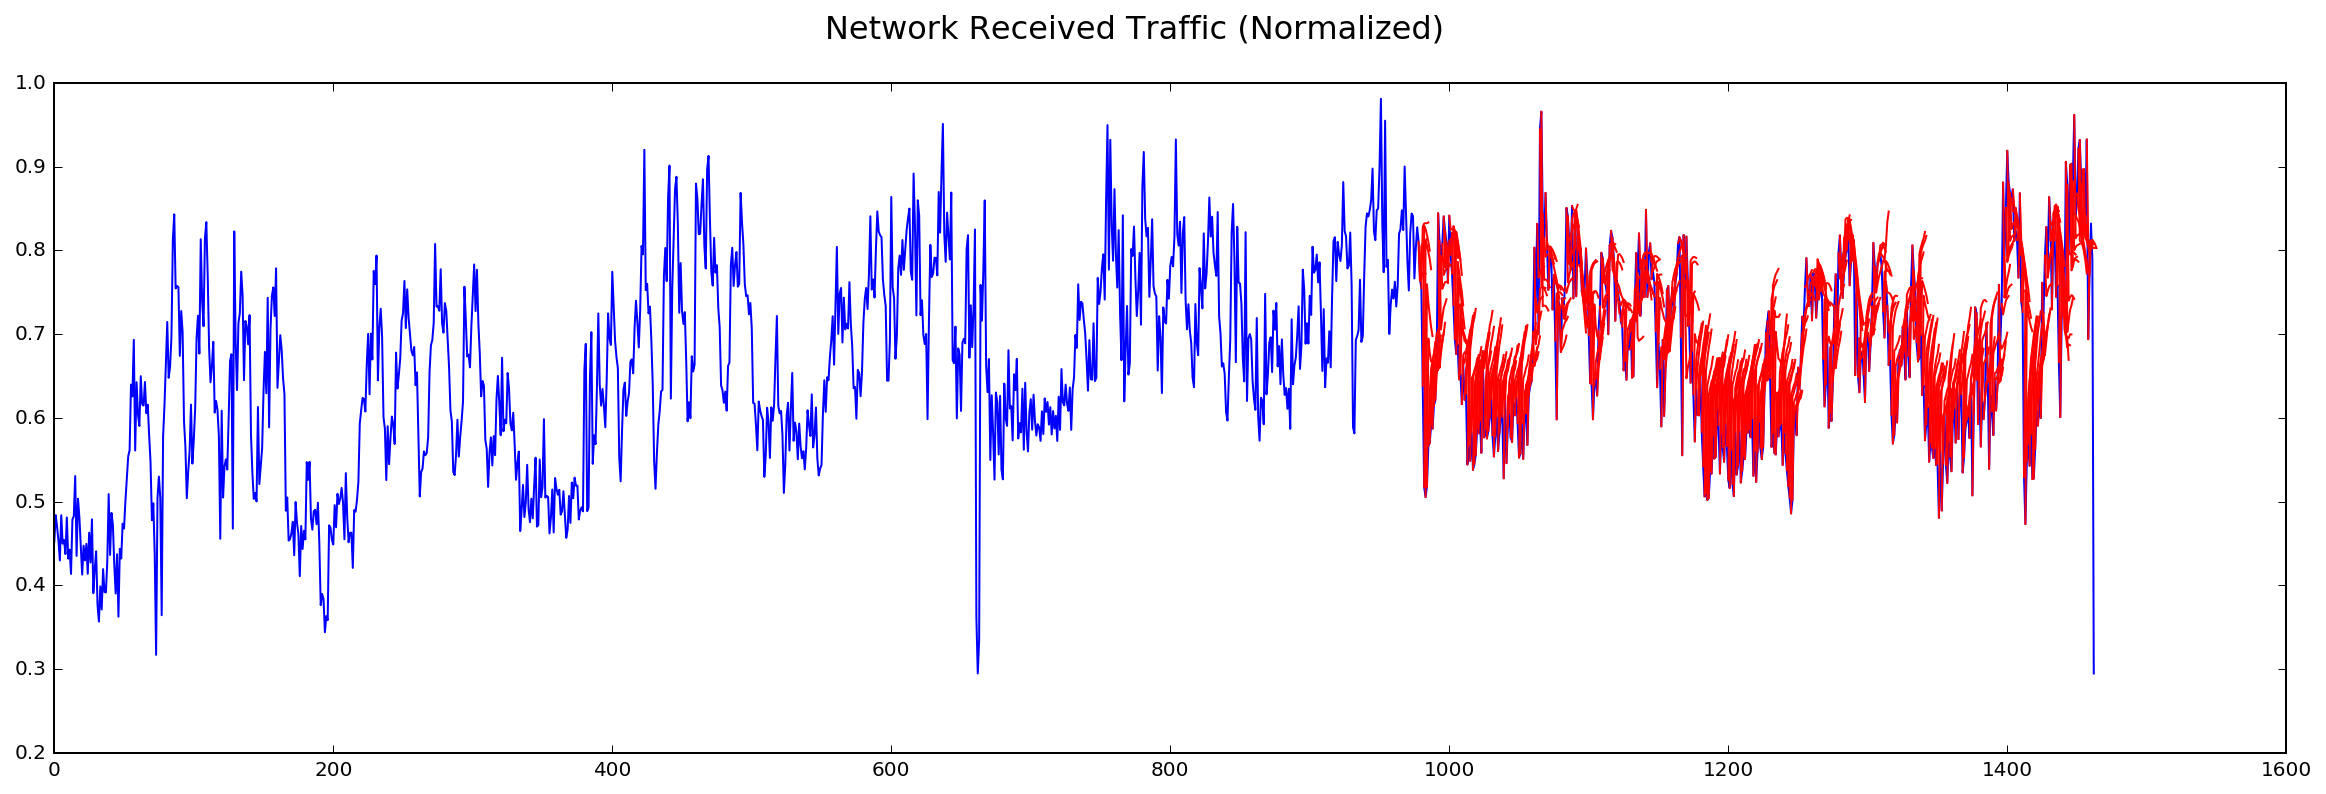

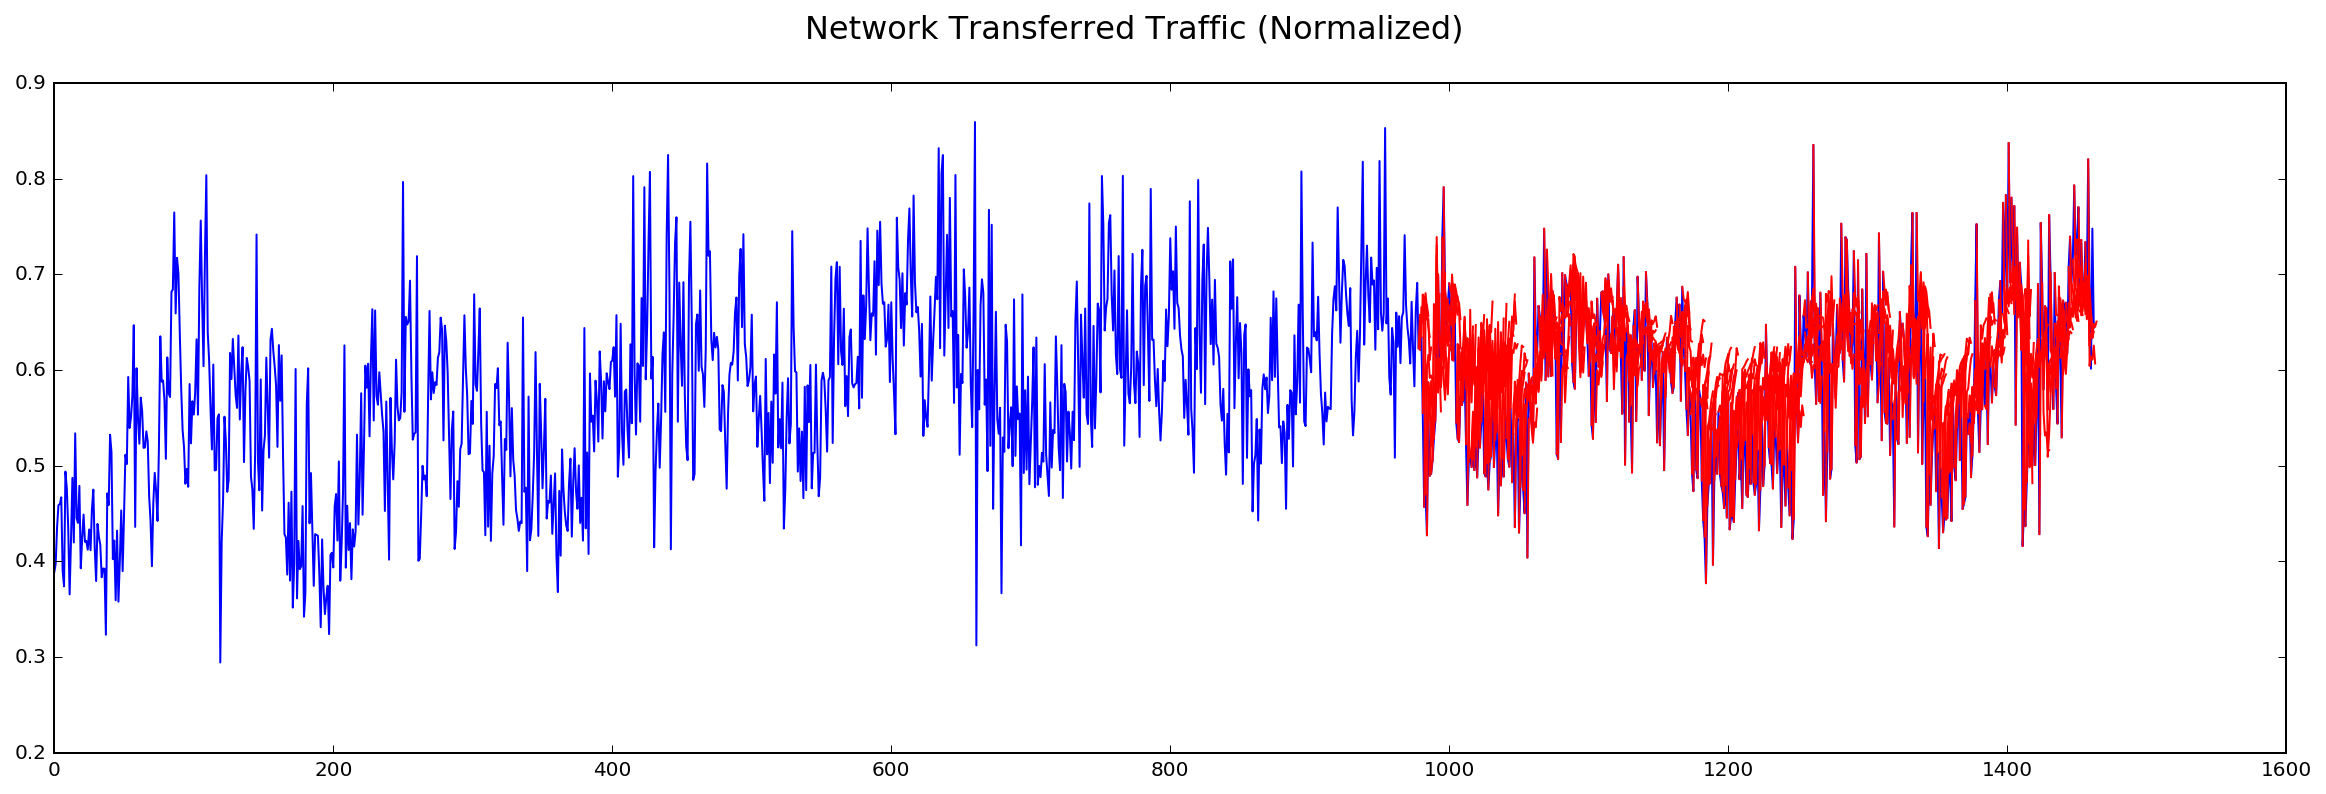

In [17]:
# plot forecasts with normalized data
def plot_forecasts_normalized(dataset, forecasts, n_test, title):
    plt.figure(figsize=(20,6))
    plt.suptitle(title, fontsize=16) 
    # plot the entire dataset in blue
    plt.plot(dataset)
    # plot the forecasts in red
    n_test=n_test+2
    for i in range(len(forecasts)):
        off_s = len(dataset) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [dataset[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()

plot_forecasts_normalized(dataset_receive, forecasts_received, n_test, "Network Received Traffic (Normalized)")
plot_forecasts_normalized(dataset_transfer, forecasts_transferred, n_test, "Network Transferred Traffic (Normalized)")

### Plot Forecast with the Original Data

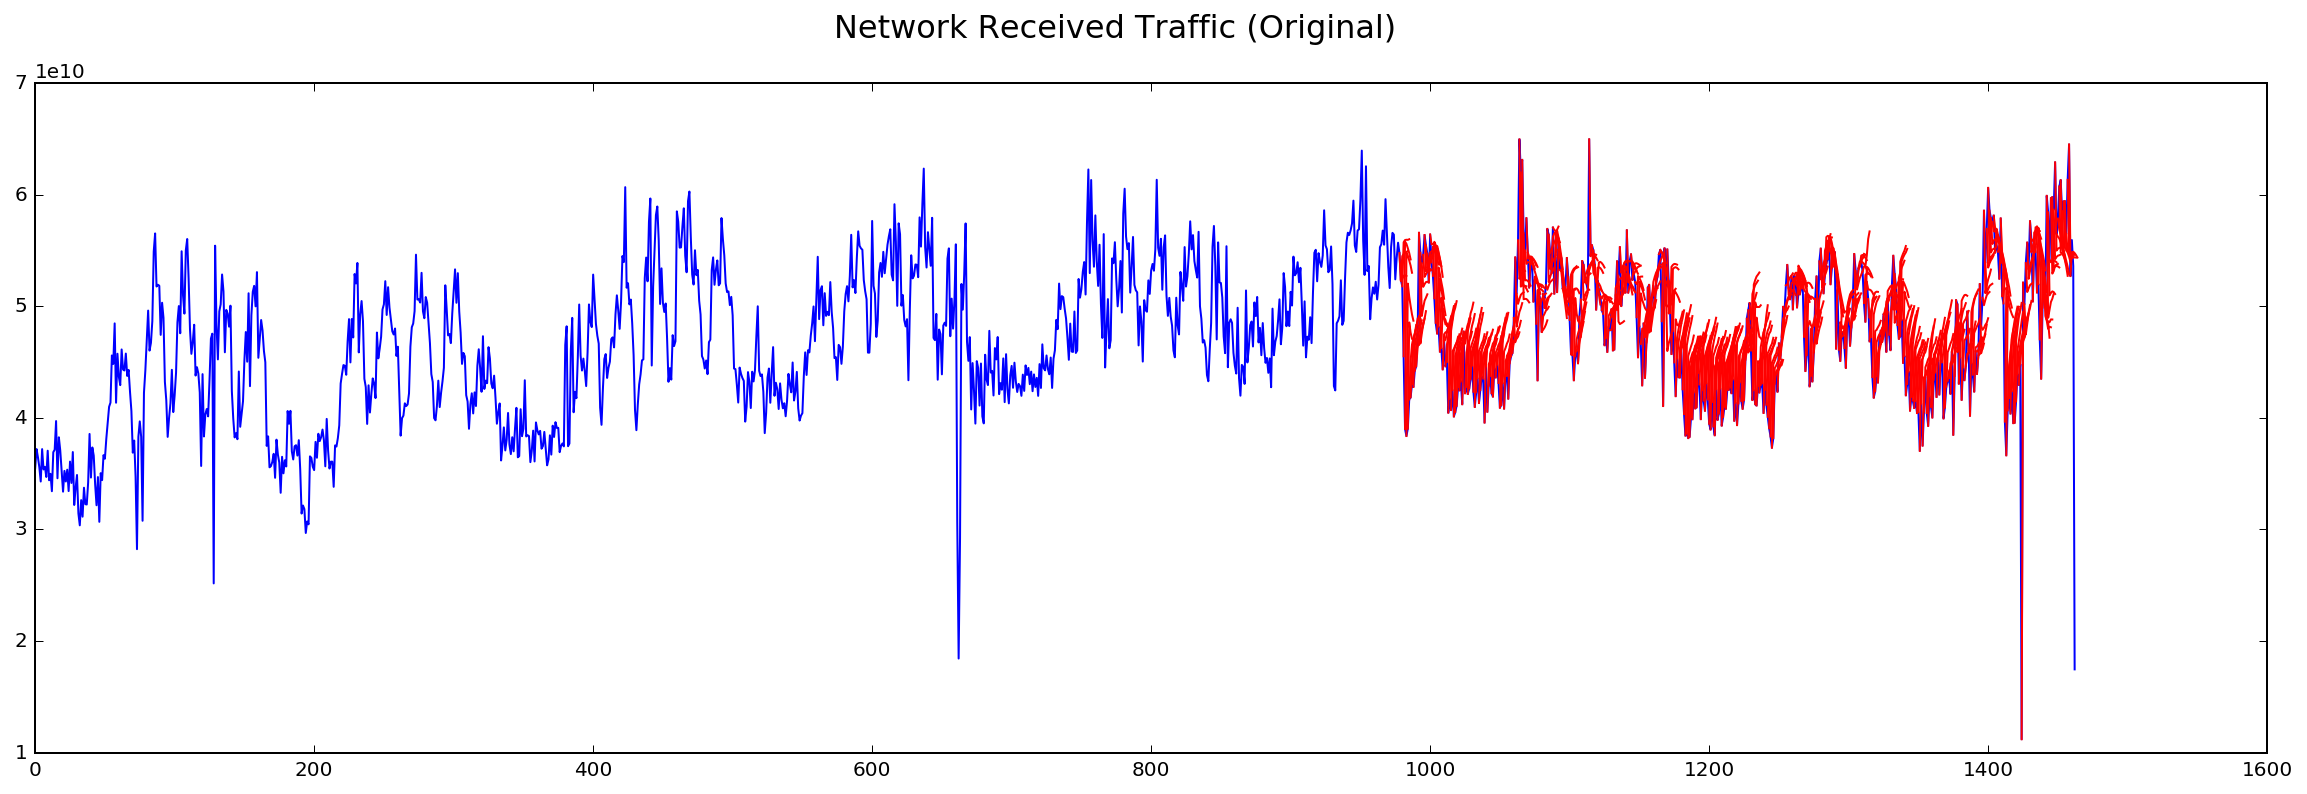

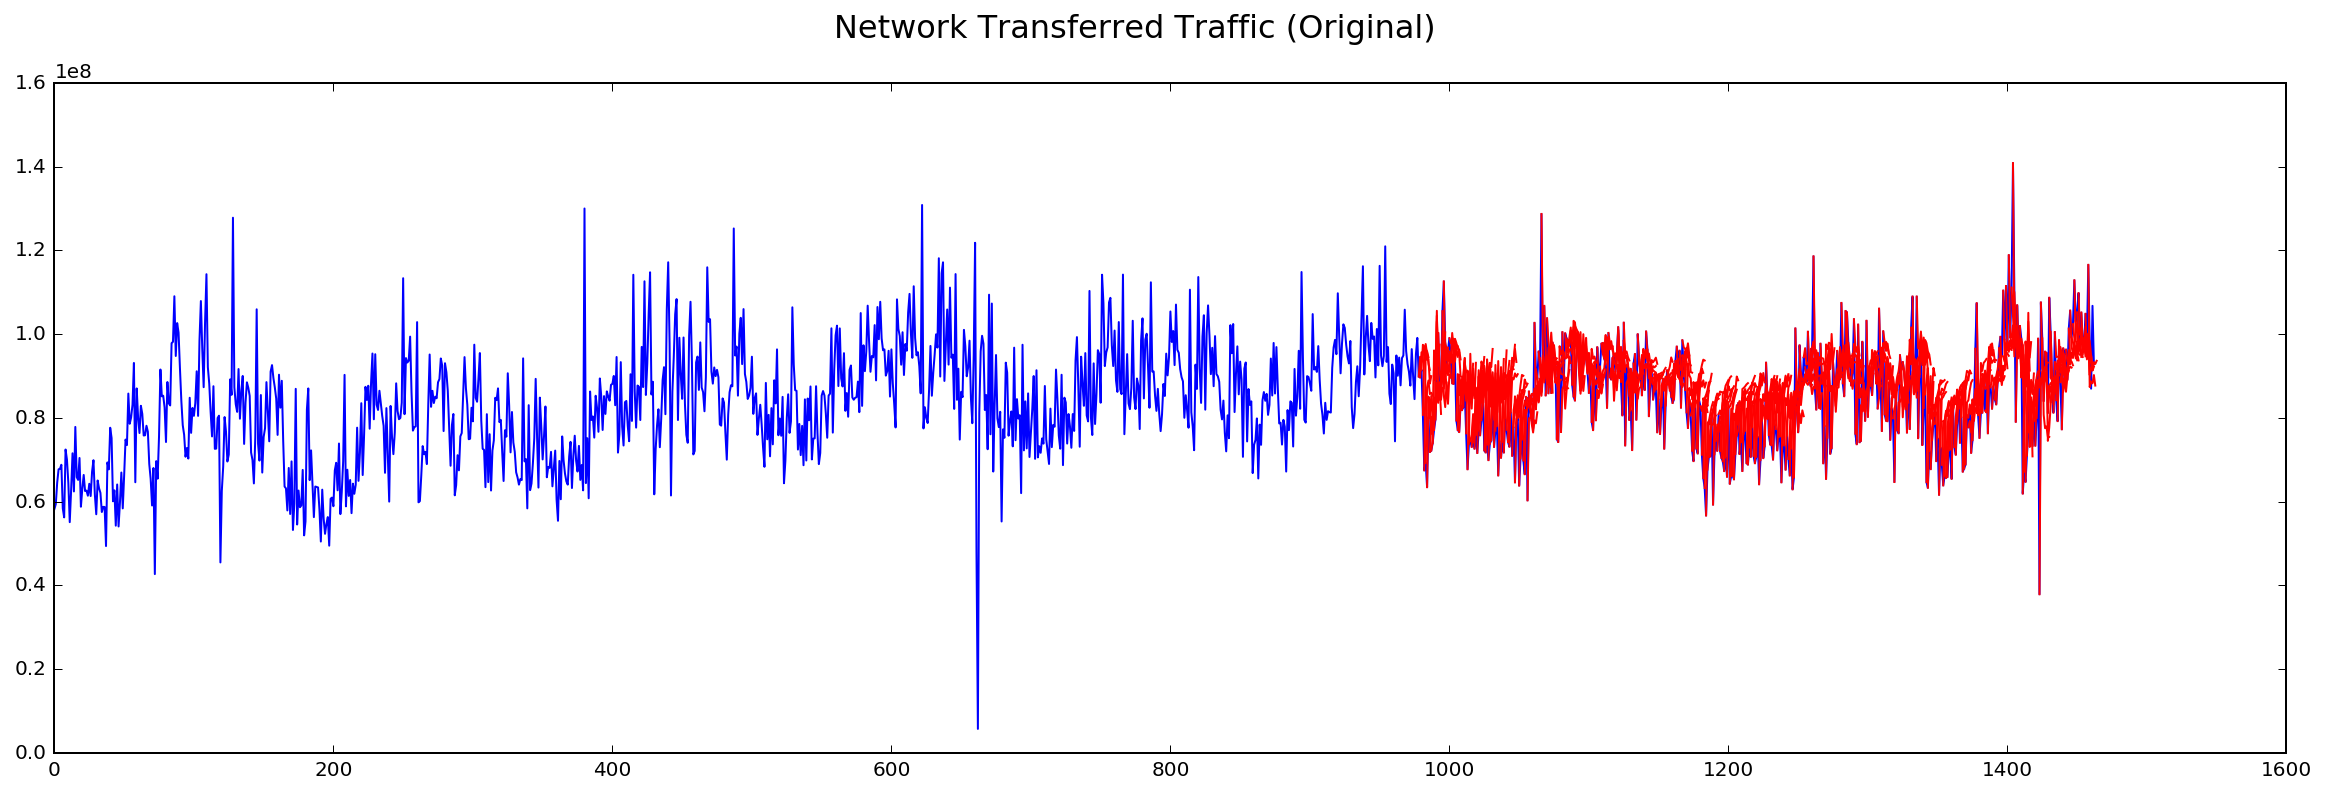

In [34]:
# plot the forecasts in the context of the original dataset
def plot_forecasts_original(dataset, forecasts, n_test, scaler, title):
    plt.figure(figsize=(20,6))
    plt.suptitle(title, fontsize=16)
    # plot the entire dataset in blue
    data1=scaler.inverse_transform(dataset)
    forecasts_origin=scaler.inverse_transform(forecasts)
    plt.plot(data1)
    # plot the forecasts in red
    n_test=n_test+2
    
    for i in range(len(forecasts_origin)):
        off_s = len(dataset) - n_test + i - 1
        off_e = off_s + len(forecasts_origin[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        s1 = pd.Series([data1[off_s]])
        s2 = pd.Series(forecasts_origin[i])
        s3 = s1.append(s2)
        yaxis = np.asarray(s3) 
        plt.plot(xaxis, yaxis, color='red')

    # show the plot
    plt.show()

    
    
plot_forecasts_original(dataset_receive, forecasts_received, n_test, scaler, "Network Received Traffic (Original)")
plot_forecasts_original(dataset_transfer, forecasts_transferred, n_test, scaler2, "Network Transferred Traffic (Original)")


## Build One-step LSTM Model

Apart from predicting the next few hours of network traffic, there would also be cases when you want to forecast only the  next hour network data. In such cases, the model will make a forecast for the next hour based on all previous network data. Then, the actual expected data for the next hour from the test dataset will be taken and made available to the model for the forecast on the next time step.

### Create Training and Testing Data
First of all, let's create the training and testing dataset by making the training mini-batches and splitting data into training data and test dataset.

In [35]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [36]:
def split_dataset(dataset, train_test_split=0.67,look_back=1):
    # split into train and test sets
    train_size = int(len(dataset) * train_test_split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    return trainX,trainY,testX,testY

Here we set *look_back* to 1, which indicates that we will use the data of the previous 24 hours as input to predict the next time step. This is because the data presents certain patterns within an hour as discussed in the Data Analysis section. 

In [37]:
look_back=24
trainX,trainY,testX,testY=split_dataset(dataset_receive,look_back=look_back)
train_transferX, train_transferY, test_transferX, test_transferY=split_dataset(dataset_transfer,look_back=look_back)

### Build LSTM Model
In this section, we create a 2 layer model. The first layer is LSTM and the second layer is fully connected layer.

In [38]:
def build_1step_lstm(look_back):
    # fix random seed for reproducibility
    np.random.seed(7)
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(output_dim=256, input_shape=(1, look_back),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256,return_sequences=False))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

receive_1step_model=build_1step_lstm(look_back)
transfer_1step_model=build_1step_lstm(look_back)

### Train Model

In [43]:
epochs=2000
batch=100

receive_1step_model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch, verbose=2)

Epoch 1/2000
0s - loss: 4.9463e-04
Epoch 2/2000
0s - loss: 4.8041e-04
Epoch 3/2000
0s - loss: 5.2497e-04
Epoch 4/2000
0s - loss: 6.5303e-04
Epoch 5/2000
0s - loss: 6.0615e-04
Epoch 6/2000
0s - loss: 5.6487e-04
Epoch 7/2000
0s - loss: 5.4089e-04
Epoch 8/2000
0s - loss: 5.3865e-04
Epoch 9/2000
0s - loss: 4.6777e-04
Epoch 10/2000
0s - loss: 4.6449e-04
Epoch 11/2000
0s - loss: 4.6866e-04
Epoch 12/2000
0s - loss: 4.5338e-04
Epoch 13/2000
0s - loss: 4.9148e-04
Epoch 14/2000
0s - loss: 4.6645e-04
Epoch 15/2000
0s - loss: 5.1189e-04
Epoch 16/2000
0s - loss: 4.8451e-04
Epoch 17/2000
0s - loss: 4.4856e-04
Epoch 18/2000
0s - loss: 4.2125e-04
Epoch 19/2000
0s - loss: 4.6480e-04
Epoch 20/2000
0s - loss: 4.8872e-04
Epoch 21/2000
0s - loss: 4.4627e-04
Epoch 22/2000
0s - loss: 4.3142e-04
Epoch 23/2000
0s - loss: 4.4491e-04
Epoch 24/2000
0s - loss: 5.1512e-04
Epoch 25/2000
0s - loss: 5.1778e-04
Epoch 26/2000
0s - loss: 4.4319e-04
Epoch 27/2000
0s - loss: 4.3750e-04
Epoch 28/2000
0s - loss: 4.6801e-04
E

In [44]:
transfer_1step_model.fit(train_transferX, train_transferY, nb_epoch=epochs, batch_size=batch, verbose=2)

Epoch 1/2000
0s - loss: 4.3858e-04
Epoch 2/2000
0s - loss: 4.2030e-04
Epoch 3/2000
0s - loss: 4.1222e-04
Epoch 4/2000
0s - loss: 4.1778e-04
Epoch 5/2000
0s - loss: 4.0319e-04
Epoch 6/2000
0s - loss: 4.5214e-04
Epoch 7/2000
0s - loss: 4.1447e-04
Epoch 8/2000
0s - loss: 3.8743e-04
Epoch 9/2000
0s - loss: 4.1599e-04
Epoch 10/2000
0s - loss: 3.5931e-04
Epoch 11/2000
0s - loss: 3.8267e-04
Epoch 12/2000
0s - loss: 3.5480e-04
Epoch 13/2000
0s - loss: 4.2122e-04
Epoch 14/2000
0s - loss: 3.8341e-04
Epoch 15/2000
0s - loss: 3.9681e-04
Epoch 16/2000
0s - loss: 4.1541e-04
Epoch 17/2000
0s - loss: 3.5797e-04
Epoch 18/2000
0s - loss: 4.0908e-04
Epoch 19/2000
0s - loss: 3.9173e-04
Epoch 20/2000
0s - loss: 4.0493e-04
Epoch 21/2000
0s - loss: 4.2010e-04
Epoch 22/2000
0s - loss: 3.7067e-04
Epoch 23/2000
0s - loss: 4.2931e-04
Epoch 24/2000
0s - loss: 3.9775e-04
Epoch 25/2000
0s - loss: 4.0405e-04
Epoch 26/2000
0s - loss: 3.8768e-04
Epoch 27/2000
0s - loss: 4.0902e-04
Epoch 28/2000
0s - loss: 4.0054e-04
E

### Make Prediction and Evaluate

In [41]:
def predict_dataset(dataset, trainX, trainY ,testX, testY, scaler, model):
    # make predictions
    trainPredict1 = model.predict(trainX)
    testPredict1 = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict1)
    trainY_origin = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict1)
    testY_origin = scaler.inverse_transform([testY])
    
    print("  Normalized Score:")
    trainScore1 = math.sqrt(mean_squared_error([trainY][0], trainPredict1[:,0]))
    print('    Train Score: %.2f RMSE' % (trainScore1))
    testScore1 = math.sqrt(mean_squared_error([testY][0], testPredict1[:,0]))
    print('    Test Score: %.2f RMSE' % (testScore1))
    
    print("  Original Score:")
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_origin[0], trainPredict[:,0]))
    print('    Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_origin[0], testPredict[:,0]))
    print('    Test Score: %.2f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    return trainPredictPlot, testPredictPlot

In [45]:
# predict for received network dataset
print("Received network traffic:")
trainPredictPlot_receive,testPredictPlot_receive=predict_dataset(dataset_receive, trainX, trainY ,testX, testY, scaler, receive_1step_model)

print("Transferred network traffic:")
# predict for transferred network dataset
trainPredictPlot_transfer,testPredictPlot_transfer=predict_dataset(dataset_transfer, train_transferX, train_transferY ,test_transferX, test_transferY, scaler2, transfer_1step_model)

Received network traffic:
  Normalized Score:
    Train Score: 0.01 RMSE
    Test Score: 0.08 RMSE
  Original Score:
    Train Score: 556508630.13 RMSE
    Test Score: 4348540132.74 RMSE
Transferred network traffic:
  Normalized Score:
    Train Score: 0.01 RMSE
    Test Score: 0.09 RMSE
  Original Score:
    Train Score: 988593.26 RMSE
    Test Score: 12755285.38 RMSE


### Plot Forecast

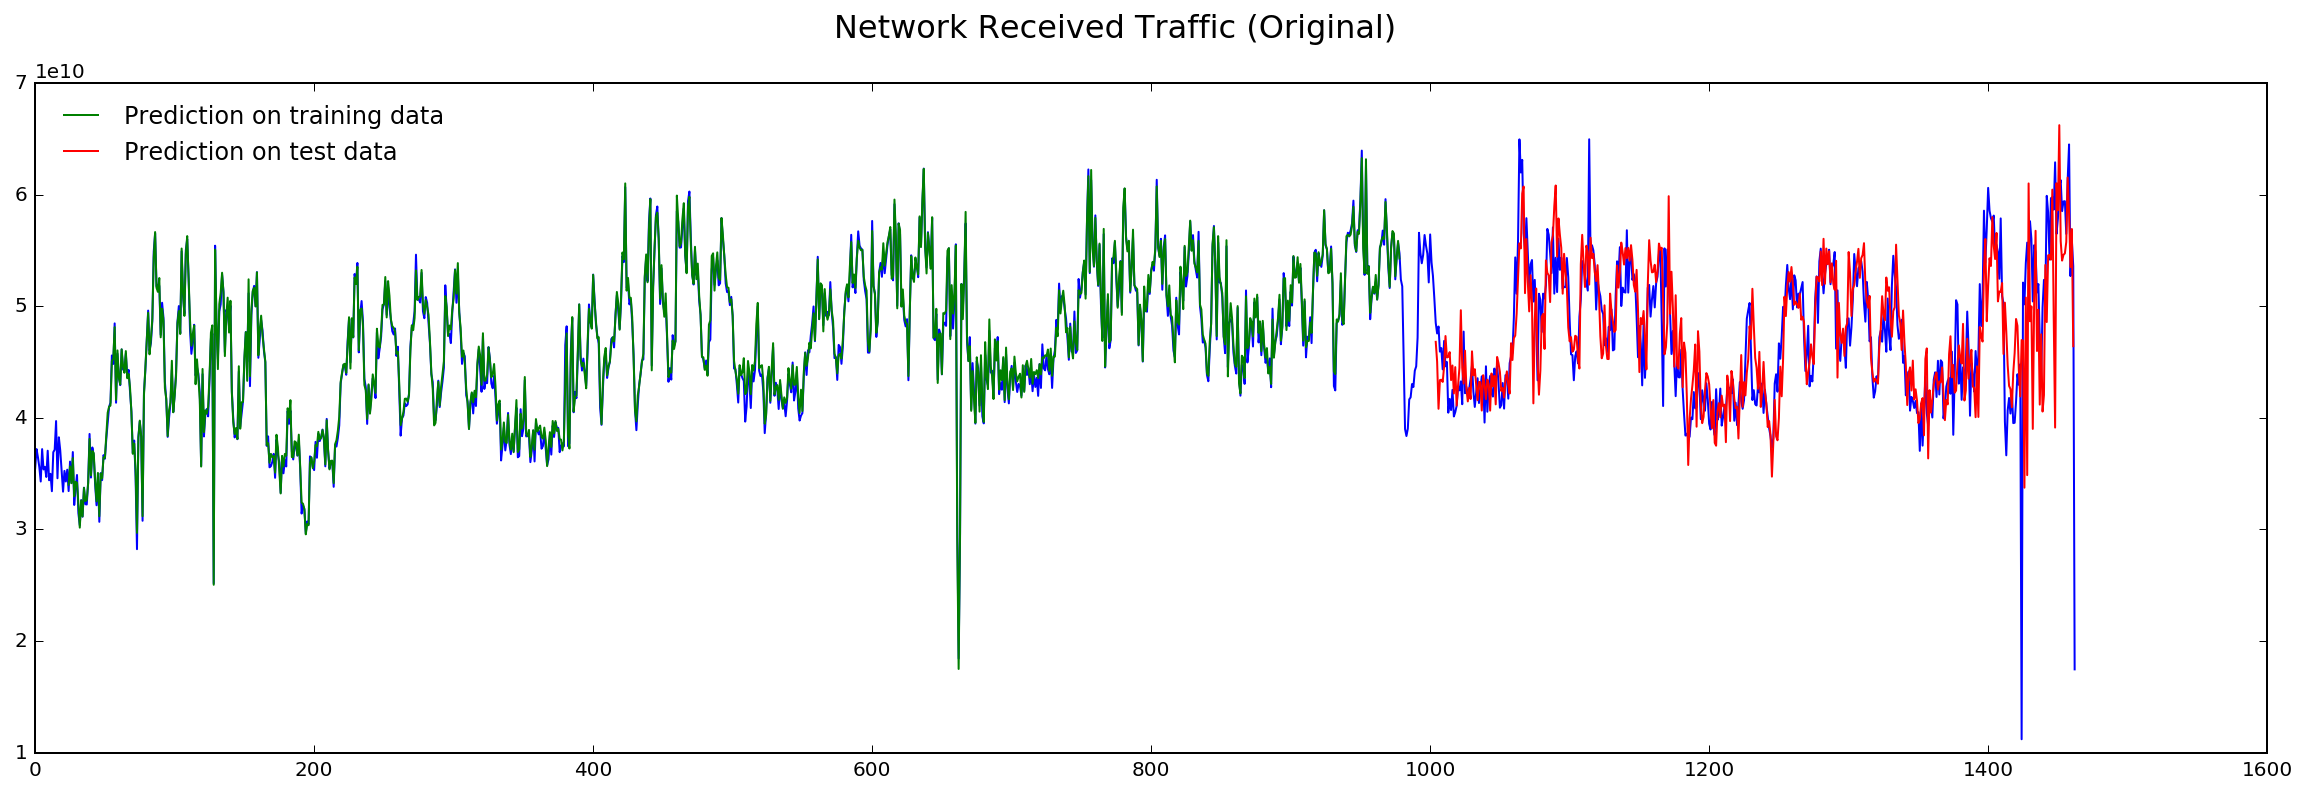

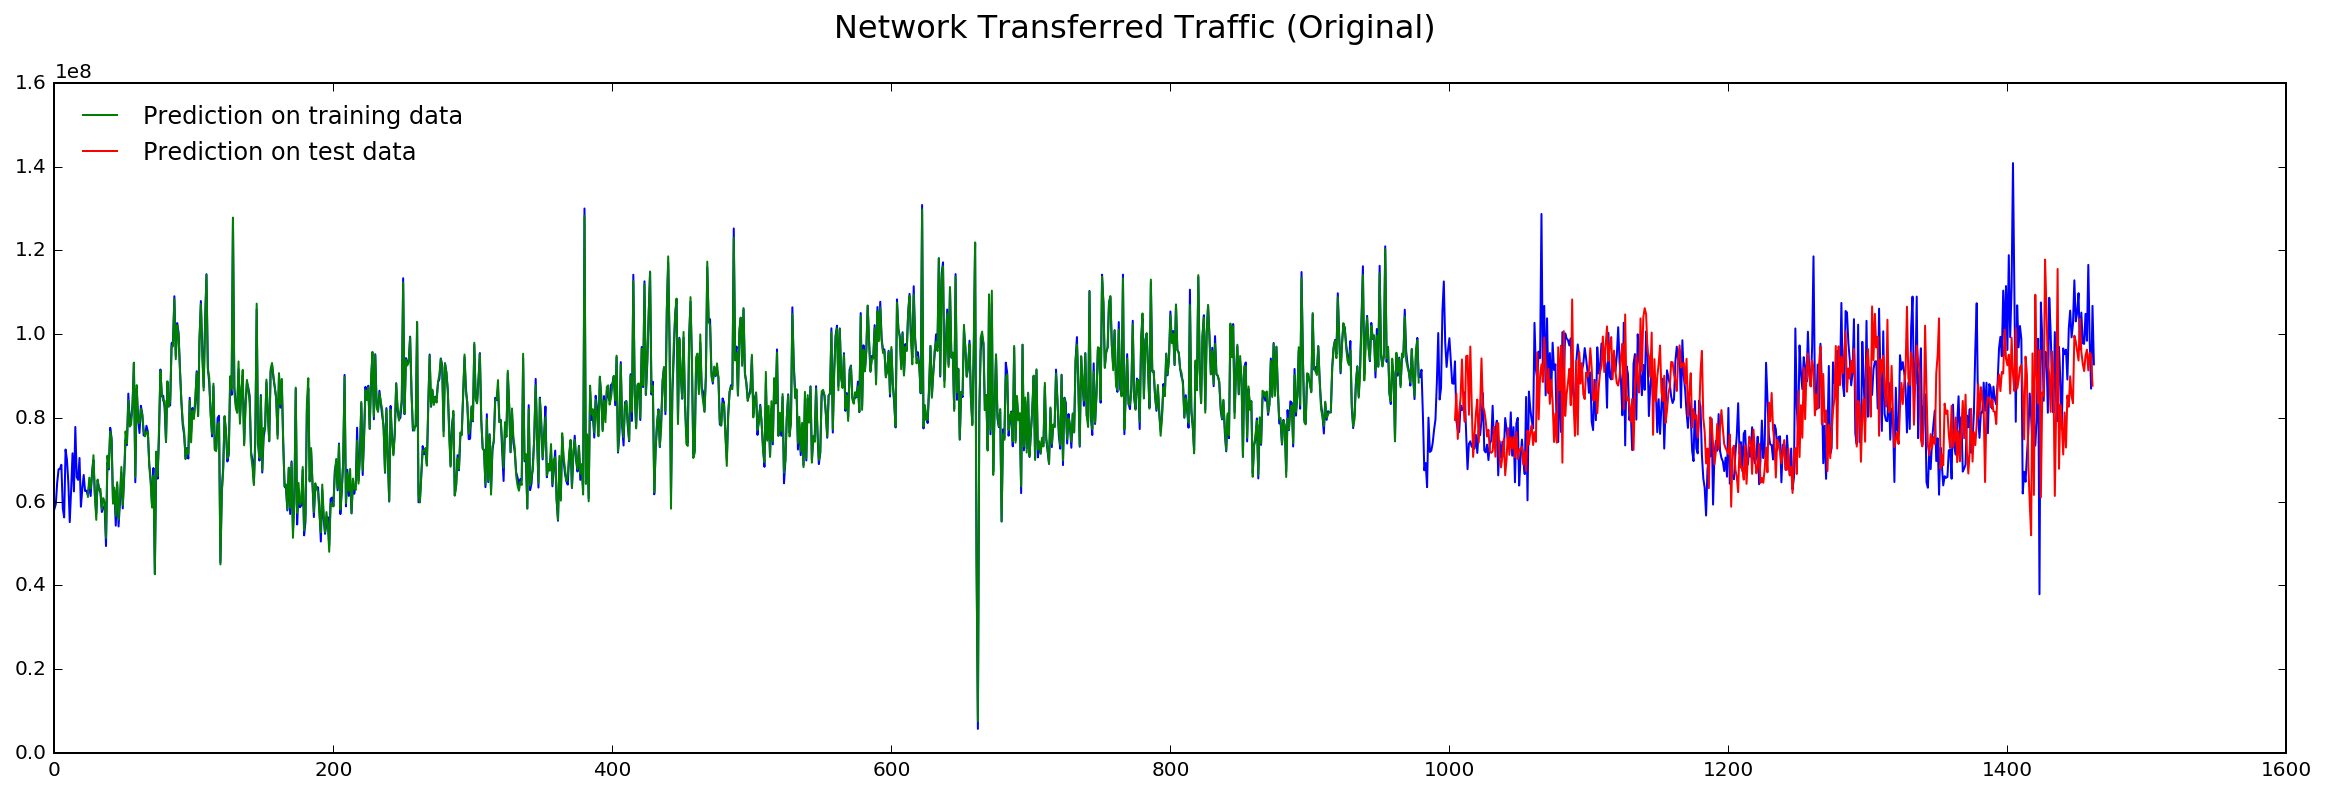

In [46]:
def plot_1step_forecase(dataset, trainPredictPlot, testPredictPlot, scaler, title):
    plt.figure(figsize=(20,6))
    plt.suptitle(title, fontsize=16)
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot, label="Prediction on training data")
    plt.plot(testPredictPlot, label="Prediction on test data")
    plt.legend(loc='upper left', frameon=False)
    plt.show()

# plot baseline and predictions for received traffic data
plot_1step_forecase(dataset_receive, trainPredictPlot_receive, testPredictPlot_receive, scaler, "Network Received Traffic (Original)")

# plot baseline and predictions for transferred traffic data
plot_1step_forecase(dataset_transfer, trainPredictPlot_transfer, testPredictPlot_transfer, scaler2, "Network Transferred Traffic (Original)")

## Save Model

Both the multi-step LSTM and one-step LSTM create 2 models respectively, one for received network traffic and one for transferred network traffic, thus we have 4 models created in total. In order to reuse these models for similar data predictions, without having to go through the training process again, we can save these models as follows.  

In [48]:

model_file_1step_rev="model_file_1step_rev.h5"
model_file_1step_trasnfer="model_file_1step_transfer.h5"

model_file_mstep_rev="model_file_mstep_rev.h5"
model_file_mstep_transfer="model_file_mstep_transfer.h5"

transfer_1step_model.save(model_file_1step_trasnfer)
receive_1step_model.save(model_file_1step_rev)
model_transferred.save(model_file_mstep_transfer)
model_received.save(model_file_mstep_rev)

transfer_1step_model.save_weights('weights_'+model_file_1step_trasnfer)
receive_1step_model.save_weights('weights_'+model_file_1step_rev)
model_transferred.save_weights(model_file_mstep_transfer)
model_received.save_weights(model_file_mstep_rev)

In [49]:
!ls -al

total 10049064
drwx------  2 sffc-3691fbb0f320c6-8c20818cd6ff users       4096 Jul 21 02:49 .
drwx------ 11 sffc-3691fbb0f320c6-8c20818cd6ff users       4096 Jul 21 21:41 ..
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users 5922295808 Jul  4 04:54 core.38527
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users      11784 Jul 21 02:47 data_receive.pkl.npy
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users      11784 Jul 21 23:48 dataset_receive.pkl.npy
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users      11784 Jul 21 23:48 dataset_trasnfer.pkl.npy
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804480 Jul 22 06:33 model_file_1step_rev.h5
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804432 Jul 21 00:25 model_file_1step_rev.model
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804480 Jul 22 06:33 model_file_1step_transfer.h5
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804480 Jul 21 00:25 model_file_1step_transfer.model
-rw-------  1 sff

### Load Model and Run in Production

To use these models in other production environments for data forecasting, we can simply load the model and its parameters (i.e. weights) as follows. We can now call the model to do predictions by providing the input dataset.

Note that the dataset must be in the same format as our training dataset used in this notebook.

In [63]:
from keras.models import load_model
model=load_model(model_file_1step_rev)
model.load_weights('weights_'+model_file_1step_rev)

## Summary 

To predict the network traffic of Bluemix platform, we've used two types of LSTM models in this notebook:

- Multi-step LSTM model to forecast network traffic of the next 5 hours
- One-step LSTM model to forecast network traffic of the next hour

The results of the forecasting are as follows. We've normalized the root-mean-square error (RMSE) of the models to adjust the results to a common scale, allowing for comparison among RMSE of diffrerent models based on different datasets.  

- Multi-step LSTM model on network received traffic:

    - t+1 RMSE: 0.073277
    - t+2 RMSE: 0.081945
    - t+3 RMSE: 0.089421
    - t+4 RMSE: 0.095859
    - t+5 RMSE: 0.104231

- Multi-step LSTM model on network transferred traffic:

    - t+1 RMSE: 0.084037
    - t+2 RMSE: 0.085811
    - t+3 RMSE: 0.088020
    - t+4 RMSE: 0.093359
    - t+5 RMSE: 0.094424

- One-step LSTM model on network received traffic:

    - Train Score: 0.01 RMSE
    - Test Score: 0.08 RMSE
    
- One-step LSTM model on network transferred traffic:

    - Train Score: 0.01 RMSE
    - Test Score: 0.09 RMSE
    
Apparently, the one-step LSTM model produces better results than the multi-step predictions, which is reasonable since it's easier to predict one time step than to predict five. For cases such as anomaly prediction, the one-step LSTM model could provide more accurate forecasts, detecting sudden increases in network traffic and allowing for auto-scaling to handle the issue. Meanwhile, for other cases, it would be necessary to forecast a few more time-steps ahead by using the multi-step LSTM model.  

To simplify the re-usage of the processed network data as well as the LSTM models created, we've saved the data and models to files, enabling easy reloading when we apply the models to other production environments or when the kernel restarts in this notebook. 